In [1]:
from Bio import Entrez
from dotenv import load_dotenv
import os
load_dotenv()

Entrez.email = os.getenv("ENTREZ_EMAIL")
Entrez.api_key = os.getenv("ENTREZ_API_KEY")  



# API

In [ ]:
import json
import re
import requests
import time
import random
import logging
from typing import Optional
api_key = os.getenv("ENTREZ_API_KEY")   # Store your key securely
print(api_key)
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=gene&term=LMP10"
params = {
    "api_key": api_key,
    "retmode": "json", 
}
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    # Process your data
    print(data)
else:
    print(f"Error: {response.status_code} - {response.text}")

b33cc4163334cc7e1c39200bb7cb96a0f808
{'header': {'type': 'esearch', 'version': '0.3'}, 'esearchresult': {'count': '3', 'retmax': '3', 'retstart': '0', 'idlist': ['19171', '5699', '8138'], 'translationset': [], 'translationstack': [{'term': 'LMP10[All Fields]', 'field': 'All Fields', 'count': '3', 'explode': 'N'}, 'GROUP'], 'querytranslation': 'LMP10[All Fields]'}}


In [ ]:
# def call_api(url: str, params: dict | None = None, timeout: int = 60, max_retries: int = 3) -> bytes:
#     """
#     Perform an HTTP GET request to the given URL (with optional params) and return raw bytes.
#     Retries with exponential back-off (up to 3 times) on rate limit or server errors.
#     """
#     base_delay = 1  # seconds
#     for attempt in range(max_retries):
#         try:
#             if attempt > 0:
#                 delay = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.5)
#                 logging.warning(f"API request failed (attempt {attempt+1}/{max_retries}): Retrying in {delay:.1f}s...")
#                 time.sleep(delay)
#             response = requests.get(url, params=params, timeout=timeout)
#             response.raise_for_status()
#             return response.content
#         except requests.exceptions.RequestException as e:
#             status = getattr(e.response, "status_code", None)
#             if status in [429, 500, 502, 503, 504] or isinstance(e, requests.exceptions.Timeout):
#                 continue  # retry
#             else:
#                 logging.error(f"API request failed: {e}")
#                 raise
#     logging.error(f"API request failed after {max_retries} retries: {url} params={params}")
#     raise RuntimeError(f"API request failed after {max_retries} retries: {url} params={params}")

In [135]:
import json
import re
import requests
import time
import random
import logging
from typing import Optional

# Basic setup
logging.basicConfig(level=logging.INFO)
load_dotenv()

# Your API key should be securely stored or loaded from a config
NCBI_API_KEY = os.getenv("ENTREZ_API_KEY")  
load_dotenv()

# Entrez.email = os.getenv("ENTREZ_EMAIL")
# Entrez.api_key = os.getenv("ENTREZ_API_KEY")  

# Common headers and base URL
NCBI_EUTILS_BASE = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
NCBI_BLAST_BASE = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"

# Rate-limiting handling
def call_ncbi_api(url: str, params: dict | None = None, timeout: int = 60, max_retries: int = 3) -> bytes:
    base_delay = 1  # seconds
    for attempt in range(max_retries):
        try:
            if attempt > 0:
                delay = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.5)
                logging.warning(f"Retry {attempt}/{max_retries}: Waiting {delay:.1f}s before retrying...")
                time.sleep(delay)
            response = requests.get(url, params=params, timeout=timeout)
            response.raise_for_status()
            return response.content
        except requests.exceptions.RequestException as e:
            status = getattr(e.response, "status_code", None)
            if status in [429, 500, 502, 503, 504] or isinstance(e, requests.exceptions.Timeout):
                continue
            else:
                raise
    raise RuntimeError(f"Failed after {max_retries} retries for URL: {url} params={params}")

def extract_rid(response_bytes: bytes) -> Optional[str]:
    if not response_bytes:
        return None
    match = re.search(r'RID\s*=\s*([A-Z0-9]+)', response_bytes.decode('utf-8', errors='ignore'))
    return match.group(1).strip() if match else None

def load_questions(json_path: str) -> dict:
    with open(json_path, "r") as f:
        return json.load(f)

def handle_question(question: str) -> str:
    if "official gene symbol of" in question:
        term = question.split("of")[-1].strip("? ")
        return gene_alias_lookup(term)
    elif "genes related to" in question:
        disease = question.split("to")[-1].strip("? ")
        return gene_disease_lookup(disease)
    elif "chromosome is" in question and "located" in question:
        gene = question.split("is")[1].split("gene")[0].strip()
        return gene_location_lookup(gene)
    elif "Align the DNA sequence to the human genome" in question:
        seq = question.split(":")[-1].strip()
        return parse_genomic_coordinates(seq)
    elif "organism does the DNA sequence come from" in question:
        seq = question.split(":")[-1].strip()
        return identify_organism(seq)
    elif "Convert" in question and "to official gene symbol" in question:
        ensg = question.split("Convert")[-1].split("to")[0].strip()
        return ensg_to_symbol(ensg)
    elif "Is" in question and "a protein-coding gene?" in question:
        gene = question.split("Is")[-1].split("a")[0].strip()
        return is_protein_coding(gene)
    elif "gene is SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_to_gene(rsid)
    elif "chromosome does SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_location(rsid)
    else:
        return "Unknown question type."


def gene_alias_lookup(term: str) -> str:
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    search_params = {
        "db": "gene",
        "term": term,
        "retmax": 3,
        "retmode": "json",
        "api_key": NCBI_API_KEY,
    }

    result = call_ncbi_api(search_url, search_params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ",".join(ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY,
    }

    summary_result = call_ncbi_api(summary_url, summary_params)
    summary_data = json.loads(summary_result)
    for uid in ids:
        if uid in summary_data["result"]:
            return summary_data["result"][uid].get("name", "NA")
    return "NA"


def gene_disease_lookup(disease: str) -> str:
    """
    Uses esearch to find genes associated with a given disease name.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    params = {
        "db": "gene",
        "term": f"{disease}[disease]",
        "retmax": 10,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"
    
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    summary_params = {
        "db": "gene",
        "id": ",".join(ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    summary_data = json.loads(summary_result)
    names = [summary_data["result"][uid]["name"] for uid in ids if uid in summary_data["result"]]
    return ", ".join(names) if names else "NA"

def gene_location_lookup(gene: str) -> str:
    """
    Use esearch and esummary to find the chromosome location of a gene.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    params = {
        "db": "gene",
        "term": f"{gene}[gene]",
        "retmax": 1,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ids[0],
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    data = json.loads(summary_result)
    chromosome = data["result"][ids[0]].get("chromosome", "NA")
    return f"chr{chromosome}" if chromosome != "NA" else "NA"

def ensg_to_symbol(ensg: str) -> str:
    """
    Converts an Ensembl gene ID to the official gene symbol.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    search_params = {
        "db": "gene",
        "term": f"{ensg}[Source ID]",
        "retmax": 1,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, search_params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ids[0],
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    data = json.loads(summary_result)
    return data["result"][ids[0]].get("name", "NA")

def snp_to_gene(rsid: str) -> str:
    """
    Retrieves gene associated with a given SNP ID using dbSNP.
    """
    rsid = rsid.replace("rs","")
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    params = {
        "db": "snp",
        "id": rsid,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(summary_url, params)
    data = json.loads(result)
    print(data)
    # Attempt to extract gene name from snp summary
    docsum = data["result"].get(rsid)
    if not docsum:
        return "NA"
    gene_info = docsum.get("genes", {})
    if isinstance(gene_info, dict):
        return gene_info.get("name", "NA")
    elif isinstance(gene_info, list):
        return ", ".join([g.get("name", "NA") for g in gene_info])
    return "NA"

def snp_location(rsid: str) -> str:
    """
    Retrieves the chromosome location of a SNP.
    """
    rsid = rsid.replace("rs", "")
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    params = {
        "db": "snp",
        "id": rsid,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(summary_url, params)
    data = json.loads(result)
    print(data)
    docsum = data["result"].get(rsid)
    if not docsum:
        return "NA"
    chr_num = docsum.get("chr", "NA")
    return f"chr{chr_num}" if chr_num != "NA" else "NA"


import time
import re
import requests

def submit_blast_query(sequence: str) -> str:
    url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
    params = {
        "CMD": "Put",
        "PROGRAM": "blastn",
        "DATABASE": "nt",
        "QUERY": sequence,
        "MEGABLAST": "on",
        "FORMAT_TYPE": "Text",
        "HITLIST_SIZE": 5
    }
    response = requests.post(url, data=params)
    match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
    return match.group(1).strip() if match else None

def retrieve_blast_result(rid: str, wait_seconds: int = 15) -> str:
    url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
    params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
    time.sleep(wait_seconds)
    for _ in range(5):
        resp = requests.get(url, params=params)
        if "Status=WAITING" in resp.text:
            time.sleep(5)
        elif "Status=FAILED" in resp.text:
            raise RuntimeError("BLAST job failed.")
        elif "No hits found" in resp.text:
            return "No hits found"
        else:
            return resp.text
    raise TimeoutError("Timed out waiting for BLAST result.")

# def submit_blast_query(sequence: str) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "QUERY": sequence,
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "Text",
#         "HITLIST_SIZE": 5
#     }
#     response = requests.post(url, data=params)
#     match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
#     return match.group(1).strip() if match else None

# def retrieve_blast_result(rid: str, wait_seconds: int = 15) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#     time.sleep(wait_seconds)
#     for _ in range(5):
#         resp = requests.get(url, params=params)
#         if "Status=WAITING" in resp.text:
#             time.sleep(5)
#         elif "Status=FAILED" in resp.text:
#             raise RuntimeError("BLAST job failed.")
#         elif "No hits found" in resp.text:
#             return "No hits found"
#         else:
#             return resp.text
#     raise TimeoutError("Timed out waiting for BLAST result.")

def parse_genomic_coordinates(seq: str) -> str:
    # Look for line with chromosome and positions
    rid = submit_blast_query(seq)
    blast_output = retrieve_blast_result(rid)
    chr_line = re.search(r">.*chromosome\s+(\w+)[^\n]*\n", blast_output)
    start = re.search(r"Sbjct\s+(\d+)\s+\w+", blast_output)
    end = re.findall(r"Sbjct\s+(\d+)\s+\w+", blast_output)
    if chr_line and start and end:
        chr_num = chr_line.group(1)
        start_pos = start.group(1)
        end_pos = end[-1]  # last occurrence
        print("chr num:", chr_num)
        
        return f"chr{chr_num}:{start_pos}-{end_pos}"
    return "NA"

# def parse_genomic_coordinates(blast_output: str) -> str:
#     # Look for line with chromosome and positions
#     chr_line = re.search(r">.*chromosome\s+(\w+)[^\n]*\n", blast_output)
#     start = re.search(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     end = re.findall(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     if chr_line and start and end:
#         chr_num = chr_line.group(1)
#         start_pos = start.group(1)
#         end_pos = end[-1]  # last occurrence
#         return f"chr{chr_num}:{start_pos}-{end_pos}"
#     return "NA"

def extract_first_hit_line(blast_output: str) -> str:
    """
    Return the first hit line after 'Sequences producing significant alignments:'.
    """
    lines = blast_output.splitlines()
    for i, line in enumerate(lines):
        if "Sequences producing significant alignments:" in line:
            # Return the next non-empty line
            for next_line in lines[i + 1:]:
                if next_line.strip():  # skip empty lines
                    return next_line
            break
    return "NA"


def extract_first_hit_organism_from_hits_section(blast_output: str) -> str:
    """
    Extract the organism name from the first hit in the BLAST alignment section.
    """
    # Find the "Sequences producing significant alignments" section
    alignments_section = extract_first_hit_line(blast_output)
    print("match", alignments_section)
    # section = alignments_section.group(0)
    line = alignments_section.strip()
    
    # Skip the header line and get the first actual hit
    # for line in lines[1:]:
    #     line = line.strip()
    #     if not line:
    #         continue
        # Match organism name pattern in the hit line
    # organism_match = re.search(r'\b([A-Z][a-z]+ [a-z]+)\b', line)
    # print("organism:", organism_match)
    # if organism_match:
    #     sci_name = organism_match.group(1)
    #     # Map scientific to common names
    organism_map = {'Caenorhabditis elegans': 'worm',
            'Homo sapiens': 'human',
            'Danio rerio': 'zebrafish',
            'Mus musculus': 'mouse',
            'Saccharomyces cerevisiae': 'yeast',
            'Rattus norvegicus': 'rat',
            'Gallus gallus': 'chicken'}
    #     return organism_map.get(sci_name, sci_name)
    for sci_name, common_name in organism_map.items():
        if sci_name in line or common_name in line:
            print("common_name:", common_name)
            return common_name
    return "NA"



def identify_organism(sequence: str) -> str:
    """Full pipeline: submit → wait → retrieve → extract organism."""
    try:
    
        rid = submit_blast_query(sequence)
        print(f"RID: {rid}")
        result_text = retrieve_blast_result(rid)
    
        organism = extract_first_hit_organism_from_hits_section(result_text)
        return organism
    except Exception as e:
        return f"Error: {e}"




# def blast_align_human(seq: str) -> str:
#     """
#     Align DNA sequence to human genome using NCBI BLAST.
#     """
#     put_params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "XML",
#         "QUERY": seq,
#         "HITLIST_SIZE": 1
#     }

#     response = call_ncbi_api(NCBI_BLAST_BASE, put_params)
#     rid = extract_rid(response)
#     if not rid:
#         return "NA"


#     for _ in range(10):
#         time.sleep(3)
#         check_params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#         result = call_ncbi_api(NCBI_BLAST_BASE, check_params)
#         text = result.decode("utf-8")
#         if "No hits found" in text:
#             return "NA"
#         match = re.search(r"(?i)(chr[0-9XYM]+:\d+-\d+)", text)
#         if match:
#             return match.group(1)
#     return "NA"

# def blast_align_species(seq: str) -> str:
#     """
#     Determine the organism for a DNA sequence using NCBI BLAST.
#     """
#     put_params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "XML",
#         "QUERY": seq,
#         "HITLIST_SIZE": 1
#     }

#     response = call_ncbi_api(NCBI_BLAST_BASE, put_params)
#     rid = extract_rid(response)
#     if not rid:
#         return "NA"

#     for _ in range(10):
#         time.sleep(3)
#         check_params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#         result = call_ncbi_api(NCBI_BLAST_BASE, check_params)
#         text = result.decode("utf-8")
#         match = re.search(r">.+\[(.+?)\]", text)
#         if match:
#             return match.group(1).lower()
#     return "NA"

def is_protein_coding(gene: str) -> str:
    import xml.etree.ElementTree as ET

    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    search_params = {
        "db": "gene",
        "term": f"{gene}[Symbol]",
        "retmode": "json",
        "retmax": 1,
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(search_url, search_params)

    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        logging.warning(f"Gene not found: {gene}")
        return "NA"
    
    gene_id = ids[0]

 
    fetch_url = NCBI_EUTILS_BASE + "efetch.fcgi"
    fetch_params = {
        "db": "gene",
        "id": gene_id,
        "retmode": "xml",
        "api_key": NCBI_API_KEY
    }
    response = call_ncbi_api(fetch_url, fetch_params)

    root = ET.fromstring(response.decode("utf-8"))

    for gene_ref in root.iter("Gene-ref"):
        
        gene_type_elem = gene_ref.find("Gene-ref_desc")
        if gene_type_elem is not None and gene_type_elem.text:
            gene_type = gene_type_elem.text.strip()
            logging.info("Gene type (desc): %s", gene_type)
            if "non-protein" in gene_type:
                return "NA" 
            else: 
                return "TRUE"
        else:
            logging.info("Gene-ref_desc not found")
            return "NA"



In [136]:
from pathlib import Path
from tqdm import tqdm
def process_json_questions(input_path: str, output_path: str) -> None:
    input_path = Path(input_path)
    output_path = Path(output_path)

    with input_path.open("r") as f:
        data = json.load(f)

    results = {}

    for task, qa_dict in data.items():
        results[task] = {}
        for question, true_answer in  tqdm(qa_dict.items()):
            try:
                predicted_answer = handle_question(question)
            except Exception as e:
                predicted_answer = f"Error: {str(e)}"
            results[task][question] = {
                "predicted": predicted_answer,
                "true": true_answer
            }

    with output_path.open("w") as f:
        json.dump(results, f, indent=2)


input_path = "/work/bioinformatics/s440708/MODULE_3_MATERIALS/data/geneturing.json"
output_path = "/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/geneturing_entrez.json"
process_json_questions(input_path, output_path)

  4%|▍         | 2/50 [00:49<18:37, 23.28s/it]

chr num: 8


  6%|▌         | 3/50 [01:07<16:17, 20.79s/it]

chr num: 10


  8%|▊         | 4/50 [01:23<14:35, 19.03s/it]

chr num: 7


 10%|█         | 5/50 [01:40<13:45, 18.34s/it]

chr num: 17


 12%|█▏        | 6/50 [01:57<13:00, 17.75s/it]

chr num: 6


 14%|█▍        | 7/50 [02:14<12:28, 17.42s/it]

chr num: 22


 16%|█▌        | 8/50 [02:32<12:19, 17.61s/it]

chr num: 21


 18%|█▊        | 9/50 [02:51<12:18, 18.00s/it]

chr num: 21


 20%|██        | 10/50 [03:07<11:42, 17.55s/it]

chr num: 18


 22%|██▏       | 11/50 [03:24<11:14, 17.29s/it]

chr num: 1


 24%|██▍       | 12/50 [03:41<10:53, 17.20s/it]

chr num: 10


 26%|██▌       | 13/50 [03:57<10:26, 16.94s/it]

chr num: 7


 28%|██▊       | 14/50 [04:14<10:05, 16.83s/it]

chr num: 14


 32%|███▏      | 16/50 [05:07<11:53, 20.98s/it]

chr num: 18


 36%|███▌      | 18/50 [05:50<11:31, 21.61s/it]

chr num: 19


 38%|███▊      | 19/50 [06:07<10:23, 20.12s/it]

chr num: X


 40%|████      | 20/50 [06:23<09:29, 18.99s/it]

chr num: Xq21


 42%|████▏     | 21/50 [06:39<08:49, 18.25s/it]

chr num: 22


 44%|████▍     | 22/50 [06:56<08:15, 17.70s/it]

chr num: 16


 46%|████▌     | 23/50 [07:12<07:49, 17.38s/it]

chr num: 21


 48%|████▊     | 24/50 [07:29<07:28, 17.25s/it]

chr num: 6q26


 50%|█████     | 25/50 [07:46<07:06, 17.05s/it]

chr num: 18


 54%|█████▍    | 27/50 [08:19<06:23, 16.67s/it]

chr num: 7


 56%|█████▌    | 28/50 [08:35<06:07, 16.70s/it]

chr num: 14


 58%|█████▊    | 29/50 [08:52<05:48, 16.58s/it]

chr num: 11


 60%|██████    | 30/50 [09:09<05:34, 16.74s/it]

chr num: 19


 62%|██████▏   | 31/50 [09:25<05:16, 16.65s/it]

chr num: 8


 64%|██████▍   | 32/50 [09:42<05:00, 16.67s/it]

chr num: 9


 66%|██████▌   | 33/50 [10:13<05:58, 21.09s/it]

chr num: X


 68%|██████▊   | 34/50 [10:33<05:29, 20.57s/it]

chr num: 20


 70%|███████   | 35/50 [10:50<04:53, 19.59s/it]

chr num: 17


 72%|███████▏  | 36/50 [11:06<04:21, 18.64s/it]

chr num: 1q31


 74%|███████▍  | 37/50 [11:23<03:55, 18.10s/it]

chr num: 19


 76%|███████▌  | 38/50 [11:41<03:34, 17.84s/it]

chr num: 6q21


 78%|███████▊  | 39/50 [12:02<03:27, 18.82s/it]

chr num: 16


 80%|████████  | 40/50 [12:25<03:21, 20.12s/it]

chr num: 2


 82%|████████▏ | 41/50 [12:41<02:51, 19.00s/it]

chr num: 19


 84%|████████▍ | 42/50 [12:58<02:26, 18.29s/it]

chr num: 9


 86%|████████▌ | 43/50 [13:14<02:04, 17.72s/it]

chr num: 6


 88%|████████▊ | 44/50 [13:31<01:44, 17.46s/it]

chr num: 1


 90%|█████████ | 45/50 [13:48<01:26, 17.23s/it]

chr num: 14


 92%|█████████▏| 46/50 [14:05<01:08, 17.11s/it]

chr num: 7


 94%|█████████▍| 47/50 [14:21<00:50, 16.85s/it]

chr num: 10


 96%|█████████▌| 48/50 [14:37<00:33, 16.76s/it]

chr num: 10


 98%|█████████▊| 49/50 [14:54<00:16, 16.63s/it]

chr num: 13


100%|██████████| 50/50 [15:14<00:00, 18.29s/it]


chr num: 20


  0%|          | 0/50 [00:00<?, ?it/s]

RID: 4419DPV7013


  2%|▏         | 1/50 [00:18<14:50, 18.18s/it]

match AP038777.1 Caenorhabditis elegans CGC1 DNA, chromosome IV, com...  213     4e-51  100%      
common_name: worm
RID: 4419ZAFN016


  4%|▍         | 2/50 [00:34<13:39, 17.07s/it]

match NM_001178205.1 Saccharomyces cerevisiae S288C flocculin FLO9 (...  252     1e-62  100%      
common_name: yeast
RID: 441AGEYD016


  6%|▌         | 3/50 [00:51<13:18, 17.00s/it]

match NM_077435.7 Caenorhabditis elegans Tyrosine-protein kinase rec...  204     2e-48  100%      
common_name: worm
RID: 441B1C9F013


  8%|▊         | 4/50 [01:08<13:06, 17.10s/it]

match AC279603.1 Homo sapiens chromosome unknown clone VMRC59-111F06...  219     9e-53  100%      
common_name: human
RID: 441BJT5K016


 10%|█         | 5/50 [01:25<12:44, 16.99s/it]

match NA
RID: 441C3UX1016


 12%|█▏        | 6/50 [01:42<12:21, 16.85s/it]

match AC126930.4 Mus musculus BAC clone RP24-547J4 from 8, complete ...  267     4e-67  100%      
common_name: mouse
RID: 441CKH8Z013


 14%|█▍        | 7/50 [02:00<12:23, 17.29s/it]

match BX248091.12 Zebrafish DNA sequence from clone DKEY-257I9 in li...  204     2e-48  100%      
RID: 441D6F9V016


 16%|█▌        | 8/50 [02:17<12:04, 17.25s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  259     6e-65  100%      
common_name: yeast
RID: 441DRPVF016


 18%|█▊        | 9/50 [02:33<11:37, 17.01s/it]

match FP015956.11 Zebrafish DNA sequence from clone CH73-145C23 in l...  191     2e-44  100%      
RID: 441E7CAY016


 20%|██        | 10/50 [02:50<11:18, 16.96s/it]

match AC096561.1 Homo sapiens BAC clone RP11-257D7 from 2, complete ...  235     9e-58  100%      
common_name: human
RID: 441ESDGK016


 22%|██▏       | 11/50 [03:07<10:58, 16.87s/it]

match FQ228999.1 Rattus norvegicus TL0ADA4YM08 mRNA sequence             230     4e-56  100%        
common_name: rat
RID: 441F9UZP016


 24%|██▍       | 12/50 [03:26<11:04, 17.50s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  230     4e-56  100%      
common_name: yeast
RID: 441FW3ET016


 26%|██▌       | 13/50 [03:44<11:00, 17.84s/it]

match HG999691.4 Meleagris gallopavo genome assembly, chromosome: 12     191     2e-44  92%       
RID: 441GEYMX016


 28%|██▊       | 14/50 [04:01<10:30, 17.52s/it]

match AC239865.4 Rattus norvegicus Y Chr BAC RNAEX-139H07 (Amplicon ...  198     1e-46  100%      
common_name: rat
RID: 441GZ1D8016


 30%|███       | 15/50 [04:38<13:37, 23.35s/it]

match AC165408.5 Mus musculus chromosome 18, clone wi1-2909J7, compl...  209     5e-50  100%      
common_name: mouse
RID: 441J44T8013


 32%|███▏      | 16/50 [04:55<12:05, 21.33s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  252     1e-62  100%      
common_name: yeast
RID: 441JN2V2013


 34%|███▍      | 17/50 [05:13<11:10, 20.32s/it]

match AC121495.11 Mus musculus chromosome 18, clone RP24-181M14, com...  209     5e-50  100%      
common_name: mouse
RID: 441K6E19016


 36%|███▌      | 18/50 [05:29<10:12, 19.15s/it]

match AC192990.2 Pan troglodytes BAC clone CH251-352O19 from chromos...  235     9e-58  100%      
RID: 441KRB2C016


 38%|███▊      | 19/50 [05:47<09:41, 18.76s/it]

match OZ238778.1 Alectoris rufa genome assembly, chromosome: 13          159     6e-35  93%       
RID: 441M9HKD016


 40%|████      | 20/50 [06:04<09:11, 18.39s/it]

match CP034491.1 Eukaryotic synthetic construct chromosome 13            224     2e-54  100%      
RID: 441MUC3G016


 42%|████▏     | 21/50 [06:21<08:36, 17.82s/it]

match AP038779.1 Caenorhabditis elegans CGC1 DNA, chromosome X, comp...  228     1e-55  100%      
common_name: worm
RID: 441NBWH6013


 44%|████▍     | 22/50 [06:38<08:14, 17.66s/it]

match AC160992.2 Mus musculus BAC clone RP23-147I23 from chromosome ...  243     6e-60  100%        
common_name: mouse
RID: 441NWUNP013


 46%|████▌     | 23/50 [06:55<07:49, 17.38s/it]

match NA
RID: 441PDV4V013


 48%|████▊     | 24/50 [07:14<07:45, 17.89s/it]

match LK927544.1 Caenorhabditis elegans genome assembly C_elegans_Br...  211     1e-50  100%      
common_name: worm
RID: 441R0WF9013


 50%|█████     | 25/50 [07:31<07:17, 17.51s/it]

match AC021761.8 Homo sapiens chromosome 11, clone RP11-361M6, compl...  191     2e-44  100%      
common_name: human
RID: 441RG1DZ016


 52%|█████▏    | 26/50 [07:47<06:51, 17.14s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  211     1e-50  100%      
common_name: yeast
RID: 441S1FEH016


 54%|█████▍    | 27/50 [08:03<06:29, 16.93s/it]

match BX255914.3 Zebrafish DNA sequence from clone CH211-212G7 in li...  219     9e-53  100%      
RID: 441SH3SR016


 56%|█████▌    | 28/50 [08:20<06:08, 16.74s/it]

match CP130405.1 Cairina moschata breed yongchun chromosome 27           108     2e-19  87%       
RID: 441T1Y8W013


 58%|█████▊    | 29/50 [08:36<05:51, 16.72s/it]

match NA
RID: 441TJK9J013


 60%|██████    | 30/50 [08:53<05:32, 16.63s/it]

match AC023509.42 Homo sapiens 12 BAC RP11-793H13 (Roswell Park Canc...  204     2e-48  100%      
common_name: human
RID: 441U31VX016


 62%|██████▏   | 31/50 [09:10<05:19, 16.80s/it]

match XR_005839376.2 PREDICTED: Gallus gallus uncharacterized LOC121...  226     5e-55  100%        
common_name: chicken
RID: 441UM1X5016


 64%|██████▍   | 32/50 [09:27<05:01, 16.75s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  200     3e-47  100%      
common_name: yeast
RID: 441V5N8T016


 66%|██████▌   | 33/50 [09:44<04:46, 16.83s/it]

match AP038775.1 Caenorhabditis elegans CGC1 DNA, chromosome II, com...  255     8e-64  100%      
common_name: worm
RID: 441VNVHP013


 68%|██████▊   | 34/50 [10:00<04:27, 16.74s/it]

match BX571843.19 Zebrafish DNA sequence from clone DKEY-250K10 in l...  250     4e-62  100%      
RID: 441W6D7C016


 70%|███████   | 35/50 [10:17<04:09, 16.63s/it]

match AL928842.13 Zebrafish DNA sequence from clone CH211-279E11 in ...  193     4e-45  100%      
RID: 441WP3UD013


 72%|███████▏  | 36/50 [10:33<03:52, 16.59s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  268     1e-67  100%      
common_name: yeast
RID: 441X7ASE013


 74%|███████▍  | 37/50 [10:49<03:35, 16.54s/it]

match CR548627.7 Zebrafish DNA sequence from clone DKEYP-24A7 in lin...  187     2e-43  98%       
RID: 441XSSRD013


 76%|███████▌  | 38/50 [11:07<03:23, 16.94s/it]

match AC171241.2 Mus musculus BAC clone RP23-94E5 from chromosome 14...  204     2e-48  100%      
common_name: mouse
RID: 441Y9Y1F013


 78%|███████▊  | 39/50 [11:28<03:17, 17.95s/it]

match AC015804.14 Homo sapiens chromosome 17, clone RP11-637C24, com...  220     2e-53  100%      
common_name: human
RID: 441YXSR9013


 80%|████████  | 40/50 [11:44<02:55, 17.58s/it]

match XM_040693310.2 PREDICTED: Gallus gallus zinc finger protein 22...  207     2e-49  94%       
common_name: chicken
RID: 441ZE6R4013


 82%|████████▏ | 41/50 [12:01<02:34, 17.19s/it]

match NA
RID: 441ZYXA6016


 84%|████████▍ | 42/50 [12:17<02:15, 16.93s/it]

match CU571333.8 Zebrafish DNA sequence from clone CH73-64E16 in lin...  246     5e-61  100%      
RID: 4420GAH5013


 86%|████████▌ | 43/50 [12:37<02:04, 17.79s/it]

match AC091465.7 Mus musculus chromosome 1, clone RP23-221K1, comple...  191     2e-44  100%      
common_name: mouse
RID: 44213VDP013


 88%|████████▊ | 44/50 [12:54<01:45, 17.66s/it]

match CP029160.1 Saccharomyces cerevisiae strain SY14 chromosome I, ...  202     8e-48  100%      
common_name: yeast
RID: 4421MGCU013


 90%|█████████ | 45/50 [13:13<01:29, 17.89s/it]

match LK927918.1 Caenorhabditis elegans genome assembly C_elegans_Br...  259     6e-65  100%      
common_name: worm
RID: 44226DVR013


 92%|█████████▏| 46/50 [13:29<01:10, 17.59s/it]

match AL845337.3 Mouse DNA sequence from clone RP23-373A4 on chromos...  165     1e-36  88%       
RID: 4422RZNA013


 94%|█████████▍| 47/50 [13:46<00:52, 17.34s/it]

match CR847826.13 Zebrafish DNA sequence from clone CH211-204D2 in l...  239     7e-59  100%      
RID: 4423878D013


 96%|█████████▌| 48/50 [14:05<00:35, 17.74s/it]

match AL110485.6 Caenorhabditis elegans YAC Y46G5A, complete sequence    220     2e-53  100%        
common_name: worm
RID: 4423VN9U013


 98%|█████████▊| 49/50 [14:21<00:17, 17.30s/it]

match NA
RID: 4424B1UT013


100%|██████████| 50/50 [14:37<00:00, 17.56s/it]


match AL935181.5 Zebrafish DNA sequence from clone CH211-162K9 in li...  244     2e-60  100%      


  4%|▍         | 2/50 [00:00<00:23,  2.08it/s]WARNING:root:Retry 1/3: Waiting 1.2s before retrying...
INFO:root:Gene type (desc): adenosylmethionine decarboxylase 1 pseudogene 4
  6%|▌         | 3/50 [00:04<01:37,  2.07s/it]WARNING:root:Retry 1/3: Waiting 1.5s before retrying...
INFO:root:Gene type (desc): nodal growth differentiation factor
 12%|█▏        | 6/50 [00:14<02:15,  3.07s/it]WARNING:root:Retry 1/3: Waiting 1.3s before retrying...
INFO:root:Gene type (desc): uncharacterized LOC124909477
 14%|█▍        | 7/50 [00:19<02:37,  3.65s/it]WARNING:root:Retry 1/3: Waiting 1.3s before retrying...
INFO:root:Gene type (desc): long intergenic non-protein coding RNA 1560
 22%|██▏       | 11/50 [00:27<01:43,  2.65s/it]WARNING:root:Retry 1/3: Waiting 1.2s before retrying...
INFO:root:Gene type (desc): small EDRK-rich factor 2
 40%|████      | 20/50 [00:45<01:22,  2.75s/it]WARNING:root:Retry 1/3: Waiting 1.4s before retrying...
INFO:root:Gene type (desc): cytochrome P450 family 4 subfamily F

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1217074595'], '1217074595': {'uid': '1217074595', 'snp_id': 1217074595, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC01270', 'gene_id': '284751'}], 'acc': 'NC_000020.11', 'chr': '20', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000020.11:50298394:G:A', 'fxn_class': 'non_coding_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000020.11:g.50298395G>A,NC_000020.10:g.48914932G>A,NR_034124.1:n.351G>A,NM_001025463.1:c.*4G>A|SEQ=[G/A]|LEN=1|GENE=LINC01270:284751', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 08:57', 'ss': '8091242333,10066227061', 'allele': 'R', 'snp_class': 'sn

  4%|▍         | 2/50 [00:00<00:10,  4.50it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1241371358'], '1241371358': {'uid': '1241371358', 'snp_id': 1241371358, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.00002/3'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LRRC23', 'gene_id': '10233'}], 'acc': 'NC_000012.12', 'chr': '12', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000012.12:6906846:C:A,NC_000012.12:6906846:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000012.12:g.6906847C>A,NC_000012.12:g.6906847C>T,NC_000012.11:g.7016011C>A,NC_000012.11:g.7016011C>T,NW_003871083.2:g.108431C>A,NW_003871083.2:g.108431C>T|SEQ=[C/A/T]|LEN=1|GENE=LRRC23:10233', 'tax_id': 9606, 'orig_build': 152, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/03 14:00', '

  6%|▌         | 3/50 [00:00<00:10,  4.48it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1481036795'], '1481036795': {'uid': '1481036795', 'snp_id': 1481036795, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'SEPTIN11', 'gene_id': '55752'}], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000004.12:76988078:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.76988079G>A,NC_000004.11:g.77909232G>A|SEQ=[G/A]|LEN=1|GENE=SEPTIN11:55752', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 12:55', 'ss': '4619206312,6638843770', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '4:76988079', 'chrpos_prev_assm': '4:77909232', 'te

  8%|▊         | 4/50 [00:00<00:10,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1318850293'], '1318850293': {'uid': '1318850293', 'snp_id': 1318850293, 'allele_origin': '', 'global_mafs': [{'study': 'Estonian', 'freq': 'C=0.000223/1'}, {'study': 'GnomAD_genomes', 'freq': 'C=0.000013/2'}, {'study': 'TOPMED', 'freq': 'C=0.000011/3'}, {'study': 'ALFA', 'freq': 'C=0.000054/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PLEKHG7', 'gene_id': '440107'}], 'acc': 'NC_000012.12', 'chr': '12', 'handle': 'GNOMAD,EGCUT_WGS,TOPMED', 'spdi': 'NC_000012.12:92716297:T:C', 'fxn_class': 'intron_variant,genic_downstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000012.12:g.92716298T>C,NC_000012.11:g.93110074T>C|SEQ=[T/C]|LEN=1|GENE=PLEKHG7:440107', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 12:21', 'ss': '2913760273,367743331

 10%|█         | 5/50 [00:01<00:09,  4.53it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['996319727'], '996319727': {'uid': '996319727', 'snp_id': 996319727, 'allele_origin': '', 'global_mafs': [{'study': 'Estonian', 'freq': 'G=0.000223/1'}, {'study': 'GnomAD_genomes', 'freq': 'G=0.000013/2'}, {'study': 'TOPMED', 'freq': 'G=0.000023/6'}, {'study': 'ALFA', 'freq': 'G=0.000054/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'USP39', 'gene_id': '10713'}], 'acc': 'NC_000002.12', 'chr': '2', 'handle': 'TOPMED,EGCUT_WGS,GNOMAD', 'spdi': 'NC_000002.12:85644397:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000002.12:g.85644398A>G,NC_000002.11:g.85871521A>G|SEQ=[A/G]|LEN=1|GENE=USP39:10713', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/30 21:26', 'ss': '2776224621,3657875065,4514196501,6543232088', 'allele': 'R', 'snp_c

 12%|█▏        | 6/50 [00:01<00:09,  4.55it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['577757681'], '577757681': {'uid': '577757681', 'snp_id': 577757681, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'G=0.000998/5'}, {'study': '1000Genomes_30X', 'freq': 'G=0.000312/2'}, {'study': 'GnomAD_genomes', 'freq': 'G=0.000013/2'}, {'study': 'TOPMED', 'freq': 'G=0.000004/1'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'OXR1', 'gene_id': '55074'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': '1000GENOMES,GNOMAD,EVA,TOPMED,1000G_HIGH_COVERAGE', 'spdi': 'NC_000008.11:106397517:A:G', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000008.11:g.106397518A>G,NC_000008.10:g.107409746A>G|SEQ=[A/G]|LEN=1|GENE=OXR1:55074', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 157, 'createdate': '2014/08/21 18:1

 14%|█▍        | 7/50 [00:01<00:09,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1294482311'], '1294482311': {'uid': '1294482311', 'snp_id': 1294482311, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000034/5'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'DMXL1', 'gene_id': '1657'}], 'acc': 'NC_000005.10', 'chr': '5', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000005.10:119123113:A:C,NC_000005.10:119123113:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000005.10:g.119123114A>C,NC_000005.10:g.119123114A>G,NC_000005.9:g.118458809A>C,NC_000005.9:g.118458809A>G|SEQ=[A/C/G]|LEN=1|GENE=DMXL1:1657', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/03 02:21', 'ss': '4675567933,4675567934,6689990796', 'allele': 'V', 'snp_class': 'snv', 'chrpos': '5:1191

 16%|█▌        | 8/50 [00:01<00:09,  4.32it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['979970652'], '979970652': {'uid': '979970652', 'snp_id': 979970652, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'A=0.000083/22'}, {'study': 'ALFA', 'freq': 'A=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'KHDRBS2', 'gene_id': '202559'}], 'acc': 'NC_000006.12', 'chr': '6', 'handle': 'GNOMAD,TOPMED,HUGCELL_USP', 'spdi': 'NC_000006.12:62069659:T:A,NC_000006.12:62069659:T:C', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000006.12:g.62069660T>A,NC_000006.12:g.62069660T>C,NC_000006.11:g.62779565T>A,NC_000006.11:g.62779565T>C|SEQ=[T/A/C]|LEN=1|GENE=KHDRBS2:202559', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 18:16', 'ss': '2839711317,4705330510,6717276417,6717276418,8466311842', 'allele': 'H', 'snp

 18%|█▊        | 9/50 [00:02<00:09,  4.39it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1029002401'], '1029002401': {'uid': '1029002401', 'snp_id': 1029002401, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000013/2'}, {'study': 'TOPMED', 'freq': 'A=0.000015/4'}, {'study': 'ALFA', 'freq': 'A=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'MAJIN', 'gene_id': '283129'}], 'acc': 'NC_000011.10', 'chr': '11', 'handle': 'TOPMED,HUMAN_LONGEVITY,GNOMAD', 'spdi': 'NC_000011.10:64941860:C:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000011.10:g.64941861C>A,NC_000011.9:g.64709333C>A|SEQ=[C/A]|LEN=1|GENE=MAJIN:283129', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 08:48', 'ss': '2183031634,2900630668,4888222230,6882898190', 'allele': 'M', 'snp_class': 'snv', 'chrpos': '11:6494186

 20%|██        | 10/50 [00:02<00:09,  4.42it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1015227'], '1015227': {'uid': '1015227', 'snp_id': 1015227, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.11222/562'}, {'study': '1000Genomes_30X', 'freq': 'T=0.11071/709'}, {'study': 'ALSPAC', 'freq': 'T=0.07109/274'}, {'study': 'Estonian', 'freq': 'T=0.10312/462'}, {'study': 'GENOME_DK', 'freq': 'T=0.1/4'}, {'study': 'GoNL', 'freq': 'T=0.06212/62'}, {'study': 'KOREAN', 'freq': 'T=0.28157/825'}, {'study': 'Korea1K', 'freq': 'T=0.27729/508'}, {'study': 'Korea4K', 'freq': 'T=0.28036/2027'}, {'study': 'NorthernSweden', 'freq': 'T=0.11167/67'}, {'study': 'Qatari', 'freq': 'T=0.08333/18'}, {'study': 'SGDP_PRJ', 'freq': 'A=0.44118/60'}, {'study': 'Siberian', 'freq': 'A=0.45/9'}, {'study': 'TOMMO', 'freq': 'T=0.26316/20378'}, {'study': 'TWINSUK', 'freq': 'T=0.06742/250'}, {'study': 'Vietnamese', 'freq': 'T=0.16355/35'}, {'study': 'ALFA', 'freq': 'T=0.02951/496'}], 'global_population': '', 'gl

 22%|██▏       | 11/50 [00:02<00:08,  4.46it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1278530438'], '1278530438': {'uid': '1278530438', 'snp_id': 1278530438, 'allele_origin': '', 'global_mafs': [{'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LDLRAD4', 'gene_id': '753'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'None', 'spdi': 'NC_000018.10:13498149:CGC:C', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000018.10:g.13498151_13498152del,NC_000018.9:g.13498150_13498151del|SEQ=[GC/-]|LEN=3|GENE=LDLRAD4:753', 'tax_id': 9606, 'orig_build': 157, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 00:06', 'ss': '0', 'allele': 'N', 'snp_class': 'delins', 'chrpos': '18:13498150', 'chrpos_prev_assm': '18:13498149', 'text': '', 'snp_id_sort': '1278530438', 'clinical_sort': '0', 'cited_sort': '', 'chrpo

 24%|██▍       | 12/50 [00:02<00:08,  4.39it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['745325402'], '745325402': {'uid': '745325402', 'snp_id': 745325402, 'allele_origin': '', 'global_mafs': [{'study': 'ALSPAC', 'freq': 'C=0./0'}, {'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'TOPMED', 'freq': 'C=0.000004/1'}, {'study': 'TWINSUK', 'freq': 'C=0.00027/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CALCR', 'gene_id': '799'}], 'acc': 'NC_000007.14', 'chr': '7', 'handle': 'HUMAN_LONGEVITY,EVA_UK10K_ALSPAC,EVA_UK10K_TWINSUK,TOPMED,GNOMAD', 'spdi': 'NC_000007.14:93478431:T:C', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000007.14:g.93478432T>C,NC_000007.13:g.93107744T>C,NG_013005.1:g.101299A>G|SEQ=[T/C]|LEN=1|GENE=CALCR:799', 'tax_id': 9606, 'orig_build': 144, 'upd_build': 157, 'createdate': '2015/04/01 22:25', 'updatedate': '2

 26%|██▌       | 13/50 [00:03<00:09,  3.75it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['4704888'], '4704888': {'uid': '4704888', 'snp_id': 4704888, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.202276/1013'}, {'study': '1000Genomes_30X', 'freq': 'T=0.204403/1309'}, {'study': 'ALSPAC', 'freq': 'T=0.190451/734'}, {'study': 'Estonian', 'freq': 'T=0.150446/674'}, {'study': 'GENOME_DK', 'freq': 'T=0.2/8'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.207701/30449'}, {'study': 'GoNL', 'freq': 'T=0.161323/161'}, {'study': 'HapMap', 'freq': 'T=0.158451/45'}, {'study': 'KOREAN', 'freq': 'T=0.295904/867'}, {'study': 'Korea1K', 'freq': 'T=0.293122/537'}, {'study': 'Korea4K', 'freq': 'T=0.283578/2048'}, {'study': 'NorthernSweden', 'freq': 'T=0.17/102'}, {'study': 'PRJEB36033', 'freq': 'T=0.363636/8'}, {'study': 'Qatari', 'freq': 'T=0.217593/47'}, {'study': 'SGDP_PRJ', 'freq': 'C=0.359091/79'}, {'study': 'Siberian', 'freq': 'C=0.375/9'}, {'study': 'TOMMO', 'freq': 'T=0.276987/21451'}, {'st

 28%|██▊       | 14/50 [00:03<00:10,  3.40it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1201372088'], '1201372088': {'uid': '1201372088', 'snp_id': 1201372088, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'ZBTB25', 'gene_id': '7597'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000014.9:64489942:C:G,NC_000014.9:64489942:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.64489943C>G,NC_000014.9:g.64489943C>T,NC_000014.8:g.64956661C>G,NC_000014.8:g.64956661C>T|SEQ=[C/G/T]|LEN=1|GENE=ZBTB25:7597', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/04 06:59', 'ss': '4973758725,6959671331,6959671332', 'allele': 'B', 'snp_class': 'snv', 'chrpos': '14:64489943', 'chrpos_

 30%|███       | 15/50 [00:03<00:10,  3.49it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1324451169'], '1324451169': {'uid': '1324451169', 'snp_id': 1324451169, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'G=0.000004/1'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'MED26', 'gene_id': '9441'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'TOPMED', 'spdi': 'NC_000019.10:16613263:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000019.10:g.16613264A>G,NC_000019.9:g.16724075A>G,NG_031959.2:g.19941T>C|SEQ=[A/G]|LEN=1|GENE=MED26:9441', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 04:51', 'ss': '8069534579', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '19:16613264', 'chrpos_prev_assm': '19:16724075', 'text': '', 'snp_id_sort': '1324451169', 'clinical_sort': '0', 'cite

 32%|███▏      | 16/50 [00:04<00:10,  3.31it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['983419152'], '983419152': {'uid': '983419152', 'snp_id': 983419152, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000007/1'}, {'study': 'TOPMED', 'freq': 'G=0.000008/2'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC02055', 'gene_id': '107986980'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000008.11:136731737:A:C,NC_000008.11:136731737:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000008.11:g.136731738A>C,NC_000008.11:g.136731738A>G,NC_000008.10:g.137743981A>C,NC_000008.10:g.137743981A>G|SEQ=[A/C/G]|LEN=1|GENE=LINC02055:107986980', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 01:47', 'ss': '2873479468,4806607835,6809

 34%|███▍      | 17/50 [00:04<00:09,  3.46it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['745940901'], '745940901': {'uid': '745940901', 'snp_id': 745940901, 'allele_origin': '', 'global_mafs': [{'study': 'ALSPAC', 'freq': 'C=0./0'}, {'study': 'TWINSUK', 'freq': 'C=0.00027/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'JMJD1C', 'gene_id': '221037'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'TOPMED,GNOMAD,HUMAN_LONGEVITY,EVA_UK10K_ALSPAC,EVA_UK10K_TWINSUK', 'spdi': 'NC_000010.11:63383626:G:A,NC_000010.11:63383626:G:C', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.63383627G>A,NC_000010.11:g.63383627G>C,NC_000010.10:g.65143387G>A,NC_000010.10:g.65143387G>C,NG_053187.2:g.143263C>T,NG_053187.2:g.143263C>G,NG_053187.1:g.143449C>T,NG_053187.1:g.143449C>G|SEQ=[G/A/C]|LEN=1|GENE=JMJD1C:221037', 'tax

 36%|███▌      | 18/50 [00:04<00:08,  3.68it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1303680136'], '1303680136': {'uid': '1303680136', 'snp_id': 1303680136, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': '-=0.000007/1'}, {'study': 'ALFA', 'freq': 'AAAAAA=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'XKR9', 'gene_id': '389668'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': 'GNOMAD', 'spdi': 'NC_000008.11:70933663:AAAAA:AAAA,NC_000008.11:70933663:AAAAA:AAAAAA', 'fxn_class': 'genic_downstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000008.11:g.70933668del,NC_000008.11:g.70933668dup,NC_000008.10:g.71845903del,NC_000008.10:g.71845903dup|SEQ=[A/-/AA]|LEN=5|GENE=XKR9:389668', 'tax_id': 9606, 'orig_build': 157, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 00:41', 'ss': '6794896971', 'allele': 'N', 'snp_class': 'delins'

 38%|███▊      | 19/50 [00:04<00:07,  3.92it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1053827498'], '1053827498': {'uid': '1053827498', 'snp_id': 1053827498, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'NSMCE1', 'gene_id': '197370'}], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'GNOMAD,TOPMED,HUMAN_LONGEVITY', 'spdi': 'NC_000016.10:27251556:G:A,NC_000016.10:27251556:G:C,NC_000016.10:27251556:G:T', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000016.10:g.27251557G>A,NC_000016.10:g.27251557G>C,NC_000016.10:g.27251557G>T,NC_000016.9:g.27262878G>A,NC_000016.9:g.27262878G>C,NC_000016.9:g.27262878G>T|SEQ=[G/A/C/T]|LEN=1|GENE=NSMCE1:197370', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:5

 40%|████      | 20/50 [00:04<00:07,  4.10it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1350154096'], '1350154096': {'uid': '1350154096', 'snp_id': 1350154096, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC107986092', 'gene_id': '107986092'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000003.12:58476875:C:A,NC_000003.12:58476875:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.58476876C>A,NC_000003.12:g.58476876C>T,NC_000003.11:g.58462603C>A,NC_000003.11:g.58462603C>T|SEQ=[C/A/T]|LEN=1|GENE=LOC107986092:107986092', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 05:05', 'ss': '4565912488,6589998212'

 42%|████▏     | 21/50 [00:05<00:06,  4.23it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1037441458'], '1037441458': {'uid': '1037441458', 'snp_id': 1037441458, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000027/4'}, {'study': 'TOPMED', 'freq': 'G=0.00003/8'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105372191', 'gene_id': '105372191'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'GNOMAD,TOPMED,HUMAN_LONGEVITY', 'spdi': 'NC_000018.10:73763516:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000018.10:g.73763517A>G,NC_000018.9:g.71430752A>G|SEQ=[A/G]|LEN=1|GENE=LOC105372191:105372191', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 03:26', 'ss': '2223145436,8063345959,10040702779', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '18:7376

 44%|████▍     | 22/50 [00:05<00:06,  4.33it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['900408143'], '900408143': {'uid': '900408143', 'snp_id': 900408143, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000009/1'}, {'study': 'KOREAN', 'freq': 'T=0.005137/15'}, {'study': 'Korea1K', 'freq': 'T=0.001093/2'}, {'study': 'SGDP_PRJ', 'freq': 'A=0.5/1'}, {'study': 'ALFA', 'freq': 'G=0.000084/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'RBFOX1', 'gene_id': '54715'}], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'KOGIC,GNOMAD,KRGDB,EVA,SGDP_PRJ,HUMAN_LONGEVITY,TOMMO_GENOMICS', 'spdi': 'NC_000016.10:6759522:A:C,NC_000016.10:6759522:A:G,NC_000016.10:6759522:A:T', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000016.10:g.6759523A>C,NC_000016.10:g.6759523A>G,NC_000016.10:g.6759523A>T,NC_000016.9:g.6809524A>C,NC_000016.9:g.6

 46%|████▌     | 23/50 [00:05<00:07,  3.41it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['900532834'], '900532834': {'uid': '900532834', 'snp_id': 900532834, 'allele_origin': '', 'global_mafs': [{'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PAK1', 'gene_id': '5058'}], 'acc': 'NC_000011.10', 'chr': '11', 'handle': 'None', 'spdi': 'NC_000011.10:77334139:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000011.10:g.77334140G>A,NC_000011.9:g.77045185G>A,NG_029900.3:g.200869C>T,NG_029900.2:g.144924C>T|SEQ=[G/A]|LEN=1|GENE=PAK1:5058', 'tax_id': 9606, 'orig_build': 157, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 12:27', 'ss': '0', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '11:77334140', 'chrpos_prev_assm': '11:77045185', 'text': '', 'snp_id_sort': '0900532834', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '00773341

 48%|████▊     | 24/50 [00:06<00:08,  2.93it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1281200566'], '1281200566': {'uid': '1281200566', 'snp_id': 1281200566, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.00002/3'}, {'study': 'TOPMED', 'freq': 'T=0.000011/3'}, {'study': 'ALFA', 'freq': 'T=0.000142/2'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CCT8L2', 'gene_id': '150160'}], 'acc': 'NC_000022.11', 'chr': '22', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000022.11:16593153:C:T', 'fxn_class': '2KB_upstream_variant,upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000022.11:g.16593154C>T,NC_000022.10:g.17074044C>T|SEQ=[C/T]|LEN=1|GENE=CCT8L2:150160', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 11:09', 'ss': '2972723633,8104397695,10078386788', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '

 50%|█████     | 25/50 [00:06<00:08,  2.98it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1431266687'], '1431266687': {'uid': '1431266687', 'snp_id': 1431266687, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000014/2'}, {'study': 'TOPMED', 'freq': 'T=0.000015/4'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CACNB2', 'gene_id': '783'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000010.11:18330673:C:T', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.18330674C>T,NC_000010.10:g.18619603C>T,NG_016195.1:g.194998C>T|SEQ=[C/T]|LEN=1|GENE=CACNB2:783', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 04:57', 'ss': '4844423426,6843215050', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': 

 52%|█████▏    | 26/50 [00:06<00:07,  3.23it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['900745020'], '900745020': {'uid': '900745020', 'snp_id': 900745020, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000013/2'}, {'study': 'TOPMED', 'freq': 'G=0.000015/4'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CREB5', 'gene_id': '9586'}], 'acc': 'NC_000007.14', 'chr': '7', 'handle': 'HUMAN_LONGEVITY,TOPMED,GNOMAD', 'spdi': 'NC_000007.14:28693417:T:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000007.14:g.28693418T>G,NC_000007.13:g.28733035T>G|SEQ=[T/G]|LEN=1|GENE=CREB5:9586', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 05:26', 'ss': '2292749757,2851230749,4740119112,6748946976', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '7:28693418', 'chrpos_pre

 54%|█████▍    | 27/50 [00:07<00:06,  3.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1188606225'], '1188606225': {'uid': '1188606225', 'snp_id': 1188606225, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': '-=0.000011/3'}, {'study': 'ALFA', 'freq': '-=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'GAREM1', 'gene_id': '64762'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'TOPMED', 'spdi': 'NC_000018.10:32437853:CA:', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000018.10:g.32437854_32437855del,NC_000018.9:g.30017817_30017818del,NG_030329.1:g.37630_37631del|SEQ=[CA/-]|LEN=2|GENE=GAREM1:64762', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 01:19', 'ss': '8052828525', 'allele': 'N', 'snp_class': 'del', 'chrpos': '18:32437854', 'chrpos_prev_assm': '18:30017817', 'text

 56%|█████▌    | 28/50 [00:07<00:06,  3.63it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['902730377'], '902730377': {'uid': '902730377', 'snp_id': 902730377, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000275/41'}, {'study': 'TOPMED', 'freq': 'A=0.000208/55'}, {'study': 'ALFA', 'freq': 'A=0.000285/4'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105372323', 'gene_id': '105372323'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'GNOMAD,HUMAN_LONGEVITY,TOPMED', 'spdi': 'NC_000019.10:21603431:G:A', 'fxn_class': 'genic_downstream_transcript_variant,downstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000019.10:g.21603432G>A,NC_000019.9:g.21786234G>A|SEQ=[G/A]|LEN=1|GENE=LOC105372323:105372323', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 05:13', 'ss': '2224955918,2961459

 58%|█████▊    | 29/50 [00:07<00:05,  3.84it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1044115387'], '1044115387': {'uid': '1044115387', 'snp_id': 1044115387, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'A=0.000008/2'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'GLIS3', 'gene_id': '169792'}], 'acc': 'NC_000009.12', 'chr': '9', 'handle': 'TOPMED', 'spdi': 'NC_000009.12:4395335:G:A', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000009.12:g.4395336G>A,NC_000009.11:g.4395336G>A,NG_011782.3:g.100129C>T|SEQ=[G/A]|LEN=1|GENE=GLIS3:169792', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 01:59', 'ss': '4810326993', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '9:4395336', 'chrpos_prev_assm': '9:4395336', 'text': '', 'snp_id_sort': '10441153

 60%|██████    | 30/50 [00:07<00:05,  3.37it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['979980368'], '979980368': {'uid': '979980368', 'snp_id': 979980368, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000034/5'}, {'study': 'KOREAN', 'freq': 'A=0./0'}, {'study': 'TOMMO', 'freq': 'A=0.000026/2'}, {'study': 'TOPMED', 'freq': 'A=0.000019/5'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'FAM53B', 'gene_id': '9679'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'GNOMAD,HUMAN_LONGEVITY,KRGDB,TOMMO_GENOMICS,TOPMED', 'spdi': 'NC_000010.11:124642229:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.124642230G>A,NC_000010.10:g.126330799G>A,NG_121007.1:g.241G>A|SEQ=[G/A]|LEN=1|GENE=FAM53B:9679', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 

 62%|██████▏   | 31/50 [00:08<00:05,  3.65it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1161130206'], '1161130206': {'uid': '1161130206', 'snp_id': 1161130206, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOMMO', 'freq': 'G=0.000013/1'}, {'study': 'TOPMED', 'freq': 'T=0.000011/3'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'EMX2OS', 'gene_id': '196047'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'TOMMO_GENOMICS,TOPMED,GNOMAD', 'spdi': 'NC_000010.11:117537489:C:G,NC_000010.11:117537489:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.117537490C>G,NC_000010.11:g.117537490C>T,NC_000010.10:g.119297001C>G,NC_000010.10:g.119297001C>T,NG_013009.1:g.46C>G,NG_013009.1:g.46C>T|SEQ=[C/G/T]|LEN=1|GENE=EMX2OS:196047', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createda

 64%|██████▍   | 32/50 [00:09<00:11,  1.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['910422326'], '910422326': {'uid': '910422326', 'snp_id': 910422326, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'C=0.000004/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'ANKFN1', 'gene_id': '162282'}], 'acc': 'NC_000017.11', 'chr': '17', 'handle': 'TOPMED,HUMAN_LONGEVITY', 'spdi': 'NC_000017.11:56386693:T:C', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000017.11:g.56386694T>C,NC_000017.10:g.54464055T>C|SEQ=[T/C]|LEN=1|GENE=ANKFN1:162282', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 20:34', 'ss': '2217585896,8039263548', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '17:56386694', 'chrpos_prev_assm': '17:54464055', 'text': '', 'snp

 66%|██████▌   | 33/50 [00:10<00:11,  1.42it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1035892430'], '1035892430': {'uid': '1035892430', 'snp_id': 1035892430, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': '-=0.000312/45'}, {'study': 'Korea1K', 'freq': '-=0./0'}, {'study': 'TOMMO', 'freq': '-=0.000052/4'}, {'study': 'TOPMED', 'freq': '-=0.000306/81'}, {'study': 'ALFA', 'freq': 'AA=0.000184/3'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'TSPAN15', 'gene_id': '23555'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'TOMMO_GENOMICS,KOGIC,TOPMED,GNOMAD', 'spdi': 'NC_000010.11:69545997:AACAA:AA', 'fxn_class': 'non_coding_transcript_variant,genic_downstream_transcript_variant,3_prime_UTR_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.69546000_69546002del,NC_000010.10:g.71305756_71305758del,XR_001747072.2:n.3914_3916del,XR_001747072.1:n.3915_3917del,XM_

 68%|██████▊   | 34/50 [00:10<00:08,  1.79it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1255093658'], '1255093658': {'uid': '1255093658', 'snp_id': 1255093658, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'TENM3', 'gene_id': '55714'}], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOPMED', 'spdi': 'NC_000004.12:182376796:G:A', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000004.12:g.182376797G>A,NC_000004.11:g.183297950G>A,NG_042859.1:g.138367G>A|SEQ=[G/A]|LEN=1|GENE=TENM3:55714', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/04 00:41', 'ss': '4644930749', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '4:182376797', 'chrpos_prev_assm': '4:183297950', 'text': '', 'snp_id_sort': '

 70%|███████   | 35/50 [00:10<00:06,  2.18it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1257276516'], '1257276516': {'uid': '1257276516', 'snp_id': 1257276516, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000027/4'}, {'study': 'TOPMED', 'freq': 'A=0.000019/5'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC100506403', 'gene_id': '100506403'}], 'acc': 'NC_000021.9', 'chr': '21', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000021.9:35469253:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000021.9:g.35469254G>A,NC_000021.8:g.36841552G>A,NG_011402.2:g.520457C>T|SEQ=[G/A]|LEN=1|GENE=LOC100506403:100506403', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 10:31', 'ss': '8101062808,10075213541', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '21:35469254'

 72%|███████▏  | 36/50 [00:11<00:05,  2.59it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['563369098'], '563369098': {'uid': '563369098', 'snp_id': 563369098, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.0002/1'}, {'study': '1000Genomes_30X', 'freq': 'T=0.000312/2'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000015/4'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC01673', 'gene_id': '105372763'}], 'acc': 'NC_000021.9', 'chr': '21', 'handle': 'TOPMED,1000GENOMES,1000G_HIGH_COVERAGE,EVA,GNOMAD', 'spdi': 'NC_000021.9:27644462:G:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000021.9:g.27644463G>T,NC_000021.8:g.29016782G>T|SEQ=[G/T]|LEN=1|GENE=LINC01673:105372763', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 157, 'createdate': '2014/08/21 18:13', 'updatedate': '2024/

 74%|███████▍  | 37/50 [00:11<00:04,  2.97it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1032834815'], '1032834815': {'uid': '1032834815', 'snp_id': 1032834815, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'FNDC3B', 'gene_id': '64778'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000003.12:172058741:G:T', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant,5_prime_UTR_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.172058742G>T,NC_000003.11:g.171776532G>T,XM_047448752.1:c.-2099G>T|SEQ=[G/T]|LEN=1|GENE=FNDC3B:64778', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 09:13', 'ss': '4593487390,6615009489', 'allele': 'K', 's

 76%|███████▌  | 38/50 [00:11<00:03,  3.32it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['552952471'], '552952471': {'uid': '552952471', 'snp_id': 552952471, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'A=0.0002/1'}, {'study': '1000Genomes_30X', 'freq': 'A=0.000156/1'}, {'study': 'GnomAD_genomes', 'freq': 'A=0.000013/2'}, {'study': 'TOPMED', 'freq': 'A=0.000008/2'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'RARB', 'gene_id': '5915'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'TOPMED,HUMAN_LONGEVITY,1000GENOMES,EVA,1000G_HIGH_COVERAGE,GNOMAD', 'spdi': 'NC_000003.12:25025421:T:A', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.25025422T>A,NC_000003.11:g.25066913T>A,NG_029013.3:g.201100T>A|SEQ=[T/A]|LEN=1|GENE=RARB:5915', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 15

 78%|███████▊  | 39/50 [00:11<00:03,  3.62it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1452964195'], '1452964195': {'uid': '1452964195', 'snp_id': 1452964195, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'C=0.000008/2'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC03021', 'gene_id': '101927815'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000008.11:2578403:T:C', 'fxn_class': 'genic_downstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000008.11:g.2578404T>C,NW_003571042.1:g.545465T>C,NT_187576.1:g.746064T>C,NC_000008.10:g.2435494T>C|SEQ=[T/C]|LEN=1|GENE=LINC03021:101927815', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 23:10', 'ss': '2861915267,4771932957', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '8:2578404

 80%|████████  | 40/50 [00:12<00:02,  3.86it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['949202492'], '949202492': {'uid': '949202492', 'snp_id': 949202492, 'allele_origin': '', 'global_mafs': [], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'NECAB2', 'gene_id': '54550'}], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'HUMAN_LONGEVITY,HUGCELL_USP', 'spdi': 'NC_000016.10:83977232:G:T', 'fxn_class': 'intron_variant', 'validated': 'by-cluster', 'docsum': 'HGVS=NC_000016.10:g.83977233G>T,NC_000016.9:g.84010838G>T|SEQ=[G/T]|LEN=1|GENE=NECAB2:54550', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 20:15', 'ss': '2214319066,8495126755', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '16:83977233', 'chrpos_prev_assm': '16:84010838', 'text': '', 'snp_id_sort': '0949202492', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0083977233', 'merged_sort': '0'}}}


 82%|████████▏ | 41/50 [00:12<00:02,  4.04it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1218214598'], '1218214598': {'uid': '1218214598', 'snp_id': 1218214598, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000013/2'}, {'study': 'TOPMED', 'freq': 'C=0.000008/2'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'MIR4527HG', 'gene_id': '110175910'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000018.10:47324396:T:C', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000018.10:g.47324397T>C,NC_000018.9:g.44850768T>C|SEQ=[T/C]|LEN=1|GENE=MIR4527HG:110175910', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 02:08', 'ss': '8056580686,10034714549', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '18:47324397', 'chrpos_prev_assm': '18:4

 84%|████████▍ | 42/50 [00:12<00:01,  4.18it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1022906840'], '1022906840': {'uid': '1022906840', 'snp_id': 1022906840, 'allele_origin': '', 'global_mafs': [], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CCDC178', 'gene_id': '374864'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'HUMAN_LONGEVITY', 'spdi': 'NC_000018.10:33345988:G:A', 'fxn_class': 'intron_variant', 'validated': '', 'docsum': 'HGVS=NC_000018.10:g.33345989G>A,NC_000018.9:g.30925953G>A|SEQ=[G/A]|LEN=1|GENE=CCDC178:374864', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 01:22', 'ss': '2220717490', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '18:33345989', 'chrpos_prev_assm': '18:30925953', 'text': '', 'snp_id_sort': '1022906840', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0033345989', 'merged_sort': '0'}}}


 86%|████████▌ | 43/50 [00:12<00:01,  4.29it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1199372758'], '1199372758': {'uid': '1199372758', 'snp_id': 1199372758, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_exomes', 'freq': 'A=0.0000021/3'}, {'study': 'TOPMED', 'freq': 'A=0.0000038/1'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'RUBCN', 'gene_id': '9711'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'EVA,GNOMAD,TOPMED', 'spdi': 'NC_000003.12:197694595:G:A,NC_000003.12:197694595:G:C,NC_000003.12:197694595:G:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.197694596G>A,NC_000003.12:g.197694596G>C,NC_000003.12:g.197694596G>T,NC_000003.11:g.197421467G>A,NC_000003.11:g.197421467G>C,NC_000003.11:g.197421467G>T,NG_034153.2:g.60104C>T,NG_034153.2:g.60104C>G,NG_034153.2:g.60104C>A|SEQ=[G/A/C/T]|LEN=1|GENE=RUBCN:9711', 'tax_id':

 88%|████████▊ | 44/50 [00:12<00:01,  4.36it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1396355441'], '1396355441': {'uid': '1396355441', 'snp_id': 1396355441, 'allele_origin': '', 'global_mafs': [{'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PTPRB', 'gene_id': '5787'}], 'acc': 'NC_000012.12', 'chr': '12', 'handle': 'None', 'spdi': 'NC_000012.12:70605836:T:C', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000012.12:g.70605837T>C,NC_000012.11:g.70999617T>C,NG_029940.2:g.36604A>G|SEQ=[T/C]|LEN=1|GENE=PTPRB:5787', 'tax_id': 9606, 'orig_build': 157, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 12:07', 'ss': '0', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '12:70605837', 'chrpos_prev_assm': '12:70999617', 'text': '', 'snp_id_sort': '1396355441', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_

 90%|█████████ | 45/50 [00:13<00:01,  4.43it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1432624213'], '1432624213': {'uid': '1432624213', 'snp_id': 1432624213, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_exomes', 'freq': 'C=0.000009/7'}, {'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'SLC22A14', 'gene_id': '9389'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'GNOMAD', 'spdi': 'NC_000003.12:38305976:T:C', 'fxn_class': '5_prime_UTR_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.38305977T>C,NC_000003.11:g.38347468T>C,NM_004803.4:c.-50T>C,NM_004803.3:c.-50T>C|SEQ=[T/C]|LEN=1|GENE=SLC22A14:9389', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 04:25', 'ss': '2746974060,2791792278,6417231924,6585659058', 'allele': 'Y',

 92%|█████████▏| 46/50 [00:13<00:00,  4.47it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['937944577'], '937944577': {'uid': '937944577', 'snp_id': 937944577, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_exomes', 'freq': 'A=0.00001/6'}, {'study': 'GnomAD_genomes', 'freq': 'A=0.000034/5'}, {'study': 'TOPMED', 'freq': 'A=0.000098/26'}, {'study': 'ALFA', 'freq': 'A=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'IFFO1', 'gene_id': '25900'}], 'acc': 'NC_000012.12', 'chr': '12', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000012.12:6550833:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000012.12:g.6550834G>A,NC_000012.11:g.6660000G>A|SEQ=[G/A]|LEN=1|GENE=IFFO1:25900', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 14:00', 'ss': '2739582257,4907567454,6445810394,6900175217', 'allele': 'R', 'snp_class': 

 94%|█████████▍| 47/50 [00:13<00:00,  4.50it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1450106117'], '1450106117': {'uid': '1450106117', 'snp_id': 1450106117, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'MED13', 'gene_id': '9969'}], 'acc': 'NC_000017.11', 'chr': '17', 'handle': 'GNOMAD', 'spdi': 'NC_000017.11:61942641:T:C', 'fxn_class': '3_prime_UTR_variant,genic_downstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000017.11:g.61942642T>C,NC_000017.10:g.60020003T>C,NG_046948.1:g.127670A>G,NM_005121.3:c.*3826A>G,NM_005121.2:c.*3826A>G,XM_011525553.4:c.*3826A>G,XM_011525553.1:c.*3826A>G,XM_011525551.3:c.*3826A>G,XM_011525551.2:c.*3826A>G,XM_011525551.1:c.*3826A>G|SEQ=[T/C]|LEN=1|GENE=MED13:9969', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate':

 96%|█████████▌| 48/50 [00:13<00:00,  4.48it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['34083046'], '34083046': {'uid': '34083046', 'snp_id': 34083046, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'C=0.002196/11'}, {'study': '1000Genomes_30X', 'freq': 'C=0.002186/14'}, {'study': 'ALSPAC', 'freq': 'C=0.00467/18'}, {'study': 'Daghestan', 'freq': 'C=0.00088/1'}, {'study': 'Estonian', 'freq': 'C=0.025446/114'}, {'study': 'GnomAD_genomes', 'freq': 'C=0.006165/920'}, {'study': 'GoNL', 'freq': 'C=0.00501/5'}, {'study': 'NorthernSweden', 'freq': 'C=0.028333/17'}, {'study': 'TOPMED', 'freq': 'C=0.003578/947'}, {'study': 'TWINSUK', 'freq': 'C=0.004585/17'}, {'study': 'ALFA', 'freq': 'C=0.009264/175'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'MICU1', 'gene_id': '10367'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'ACPOP,EVA_UK10K_ALSPAC,EVA_UK10K_TWINSUK,TOPMED,EVA-GONL,PJP,1000G_HIGH_COVERAGE,GNOMAD,SSMP,EVA

 98%|█████████▊| 49/50 [00:14<00:00,  4.49it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['149916046'], '149916046': {'uid': '149916046', 'snp_id': 149916046, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': '-=0.008387/42'}, {'study': '1000Genomes_30X', 'freq': '-=0.007651/49'}, {'study': 'GnomAD_genomes', 'freq': '-=0.005884/878'}, {'study': 'TOPMED', 'freq': '-=0.006642/1758'}, {'study': 'ALFA', 'freq': 'TT=0.005125/72'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC02841', 'gene_id': '105372360'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'EVA,1000G_HIGH_COVERAGE,GNOMAD,DDI,1000GENOMES,TOPMED,HUGCELL_USP,LUNTER,SANFORD_IMAGENETICS', 'spdi': 'NC_000019.10:31547874:TT:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000019.10:g.31547876del,NC_000019.9:g.32038782del|SEQ=[T/-]|LEN=2|GENE=LINC02841:105372360', 'tax_id': 9606, 'orig_build': 134, 'upd_bui

100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1385096481'], '1385096481': {'uid': '1385096481', 'snp_id': 1385096481, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LRFN5', 'gene_id': '145581'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'GNOMAD', 'spdi': 'NC_000014.9:41877936:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.41877937C>T,NC_000014.8:g.42347140C>T,NG_051660.1:g.276082C>T|SEQ=[C/T]|LEN=1|GENE=LRFN5:145581', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 15:00', 'ss': '2926859113,6954575256', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '14:41877937', 'chrpos_prev_assm': '14:42347140', 'text': '', 'snp_id_sort': '13850964

  2%|▏         | 1/50 [00:00<00:10,  4.56it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1430464868'], '1430464868': {'uid': '1430464868', 'snp_id': 1430464868, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000013.11', 'chr': '13', 'handle': 'GNOMAD', 'spdi': 'NC_000013.11:21775298:A:C', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000013.11:g.21775299A>C,NC_000013.10:g.22349438A>C|SEQ=[A/C]|LEN=1', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/03 17:09', 'ss': '2917367580,6928713412', 'allele': 'M', 'snp_class': 'snv', 'chrpos': '13:21775299', 'chrpos_prev_assm': '13:22349438', 'text': '', 'snp_id_sort': '1430464868', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0021775299', 'merged_sort': '

  4%|▍         | 2/50 [00:00<00:10,  4.56it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['545148486'], '545148486': {'uid': '545148486', 'snp_id': 545148486, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.00006/9'}, {'study': 'GoNL', 'freq': 'C=0.001002/1'}, {'study': 'TOPMED', 'freq': 'C=0.000049/13'}, {'study': 'ALFA', 'freq': 'C=0.000069/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'ZNF843', 'gene_id': '283933'}], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'EVA-GONL,EVA_DECODE,EVA,GNOMAD,HUMAN_LONGEVITY,TOPMED', 'spdi': 'NC_000016.10:31441970:T:C', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000016.10:g.31441971T>C,NC_000016.9:g.31453292T>C|SEQ=[T/C]|LEN=1|GENE=ZNF843:283933', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 157, 'createdate': '2014/08/21 18:13', 'updatedate': '2024/11/01 06:42', 'ss': '992434507,2211757742,2942148756,36991

  6%|▌         | 3/50 [00:00<00:10,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['895485955'], '895485955': {'uid': '895485955', 'snp_id': 895485955, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.00002/3'}, {'study': 'TOMMO', 'freq': 'A=0.000013/1'}, {'study': 'TOPMED', 'freq': 'A=0.000011/3'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'ZNF681', 'gene_id': '148213'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'GNOMAD,TOPMED,TOMMO_GENOMICS', 'spdi': 'NC_000019.10:23751251:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000019.10:g.23751252G>A,NC_000019.9:g.23934054G>A|SEQ=[G/A]|LEN=1|GENE=ZNF681:148213', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 05:21', 'ss': '2961654387,6182307496,8071388512,10048151476', 'allele': 'R', 'snp_c

  8%|▊         | 4/50 [00:00<00:10,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1376217783'], '1376217783': {'uid': '1376217783', 'snp_id': 1376217783, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'DAGLA', 'gene_id': '747'}], 'acc': 'NC_000011.10', 'chr': '11', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000011.10:61726304:G:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000011.10:g.61726305G>T,NC_000011.9:g.61493777G>T|SEQ=[G/T]|LEN=1|GENE=DAGLA:747', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/03 12:26', 'ss': '4887405946,6882158337', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '11:61726305', 'chrpos_prev_assm': '11:61493777', 'text': '',

 10%|█         | 5/50 [00:01<00:09,  4.53it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1420724913'], '1420724913': {'uid': '1420724913', 'snp_id': 1420724913, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000007/1'}, {'study': 'TOPMED', 'freq': 'G=0.000004/1'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000016.10:34787361:A:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000016.10:g.34787362A>G|SEQ=[A/G]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 19:30', 'ss': '6995823380,8013480325', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '16:34787362', 'chrpos_prev_assm': '16:-1', 'text': '', 'snp_id_sort': '1420724913', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0034787362

 12%|█▏        | 6/50 [00:01<00:09,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['992486373'], '992486373': {'uid': '992486373', 'snp_id': 992486373, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000101/15'}, {'study': 'TOPMED', 'freq': 'A=0.000125/33'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC124900354', 'gene_id': '124900354'}], 'acc': 'NC_000015.10', 'chr': '15', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000015.10:47897394:G:A', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000015.10:g.47897395G>A,NC_000015.9:g.48189592G>A|SEQ=[G/A]|LEN=1|GENE=LOC124900354:124900354', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 17:16', 'ss': '2934583677,4990386083,6974968977', 'allele': 'R', 'snp_class': 'snv', 'c

 14%|█▍        | 7/50 [00:01<00:09,  4.41it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['975300764'], '975300764': {'uid': '975300764', 'snp_id': 975300764, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.00002/3'}, {'study': 'TOPMED', 'freq': 'T=0.00003/8'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000004.12:42277806:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.42277807C>T,NC_000004.11:g.42279824C>T|SEQ=[C/T]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 11:56', 'ss': '4610835678,6631020878', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '4:42277807', 'chrpos_prev_assm': '4:42279824', 'text': '', 'snp_id_sort': '0975300764', 'clinical_sort': '0', 'cited_sort': '', 'c

 16%|█▌        | 8/50 [00:01<00:09,  4.45it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['993131098'], '993131098': {'uid': '993131098', 'snp_id': 993131098, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000013/2'}, {'study': 'TOPMED', 'freq': 'G=0.000008/2'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'GNOMAD,TOPMED,HUMAN_LONGEVITY', 'spdi': 'NC_000014.9:86878419:A:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.86878420A>G,NC_000014.8:g.87344764A>G|SEQ=[A/G]|LEN=1', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 16:04', 'ss': '2204029827,4979172800,6964576266', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '14:86878420', 'chrpos_prev_assm': '14:87344764', 'text': '', 'snp_id_sort': '0993131098', 'clinical_sort

 18%|█▊        | 9/50 [00:02<00:09,  4.49it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['899883800'], '899883800': {'uid': '899883800', 'snp_id': 899883800, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000028/4'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'SPATA6', 'gene_id': '54558'}], 'acc': 'NC_000001.11', 'chr': '1', 'handle': 'GNOMAD', 'spdi': 'NC_000001.11:48285449:C:T', 'fxn_class': 'genic_downstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000001.11:g.48285450C>T,NC_000001.10:g.48751122C>T|SEQ=[C/T]|LEN=1|GENE=SPATA6:54558', 'tax_id': 9606, 'orig_build': 157, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 17:46', 'ss': '6484394645', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '1:48285450', 'chrpos_prev_assm': '1:48751122', 'text': '', 'snp_id_sort': '0899883800', 'clinica

 20%|██        | 10/50 [00:02<00:08,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['547832386'], '547832386': {'uid': '547832386', 'snp_id': 547832386, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'A=0.0002/1'}, {'study': '1000Genomes_30X', 'freq': 'A=0.000156/1'}, {'study': 'GnomAD_genomes', 'freq': 'A=0.000013/2'}, {'study': 'TOPMED', 'freq': 'A=0.000015/4'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000015.10', 'chr': '15', 'handle': '1000GENOMES,TOPMED,EVA,1000G_HIGH_COVERAGE,GNOMAD', 'spdi': 'NC_000015.10:46171631:C:A', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000015.10:g.46171632C>A,NC_000015.9:g.46463830C>A|SEQ=[C/A]|LEN=1', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 157, 'createdate': '2014/08/21 18:13', 'updatedate': '2024/11/01 17:15', 'ss': '1353303554,2934443844,4989948752,6268486981,6974583548,84189

 22%|██▏       | 11/50 [00:02<00:08,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1212113267'], '1212113267': {'uid': '1212113267', 'snp_id': 1212113267, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000007/1'}, {'study': 'TOPMED', 'freq': 'G=0.000008/2'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000022.11', 'chr': '22', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000022.11:27004395:T:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000022.11:g.27004396T>G,NC_000022.10:g.27400359T>G|SEQ=[T/G]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 11:36', 'ss': '8106861841,10080617830', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '22:27004396', 'chrpos_prev_assm': '22:27400359', 'text': '', 'snp_id_sort': '1212113267', 'clinical_sort': '0', 'cited_sor

 24%|██▍       | 12/50 [00:02<00:08,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1435895561'], '1435895561': {'uid': '1435895561', 'snp_id': 1435895561, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'A=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'THOP1', 'gene_id': '7064'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000019.10:2790113:G:A', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000019.10:g.2790114G>A,NC_000019.9:g.2790112G>A|SEQ=[G/A]|LEN=1|GENE=THOP1:7064', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 03:51', 'ss': '2959713849,8065913392,10043043390', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '19:279011

 26%|██▌       | 13/50 [00:02<00:08,  4.55it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['427884'], '427884': {'uid': '427884', 'snp_id': 427884, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes_30X', 'freq': 'G=0.02639/169'}, {'study': 'GnomAD_genomes', 'freq': 'G=0.009621/1396'}, {'study': 'Korea1K', 'freq': 'G=0.000546/1'}, {'study': 'Qatari', 'freq': 'G=0.018519/4'}, {'study': 'SGDP_PRJ', 'freq': 'A=0.5/7'}, {'study': 'TOMMO', 'freq': 'G=0.000103/8'}, {'study': 'ALFA', 'freq': 'G=0.009581/160'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000011.10', 'chr': '11', 'handle': 'TOMMO_GENOMICS,KOGIC,WEILL_CORNELL_DGM,GNOMAD,GRF,EVA,EVA_DECODE,SGDP_PRJ,1000G_HIGH_COVERAGE,SANFORD_IMAGENETICS,SC_JCM', 'spdi': 'NC_000011.10:4249145:A:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000011.10:g.4249146A>G,NC_000011.9:g.4270376A>G|SEQ=[A/G]|LEN=1', 'tax_id': 9606, 'orig_build': 80, 'u

 28%|██▊       | 14/50 [00:03<00:07,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1188706680'], '1188706680': {'uid': '1188706680', 'snp_id': 1188706680, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000004.12:77659713:C:A,NC_000004.12:77659713:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.77659714C>A,NC_000004.12:g.77659714C>T,NC_000004.11:g.78580868C>A,NC_000004.11:g.78580868C>T|SEQ=[C/A/T]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 12:55', 'ss': '4619390121,6639004687', 'allele': 'H', 'snp_class': 'snv', 'chrpos': '4:77659714', 'chrpos_prev_assm': '4:785808

 30%|███       | 15/50 [00:03<00:07,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1316126938'], '1316126938': {'uid': '1316126938', 'snp_id': 1316126938, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000013/2'}, {'study': 'TOPMED', 'freq': 'T=0.000011/3'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000018.10:28487832:G:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000018.10:g.28487833G>T,NC_000018.9:g.26067797G>T|SEQ=[G/T]|LEN=1', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 01:07', 'ss': '2955149149,8051825761,10030545120', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '18:28487833', 'chrpos_prev_assm': '18:26067797', 'text': '', 'snp_id_sort': '1316126938', 'clinical_sort': '0', 

 32%|███▏      | 16/50 [00:03<00:07,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1398189587'], '1398189587': {'uid': '1398189587', 'snp_id': 1398189587, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000034/5'}, {'study': 'Korea1K', 'freq': 'A=0.000546/1'}, {'study': 'Korea4K', 'freq': 'T=0.000138/1'}, {'study': 'TOPMED', 'freq': 'T=0.000026/7'}, {'study': 'ALFA', 'freq': 'T=0.000084/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'RELL1', 'gene_id': '768211'}], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOMMO_GENOMICS,TOPMED,GNOMAD,KOGIC,EVA', 'spdi': 'NC_000004.12:37633276:C:A,NC_000004.12:37633276:C:G,NC_000004.12:37633276:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.37633277C>A,NC_000004.12:g.37633277C>G,NC_000004.12:g.37633277C>T,NC_000004.11:g.37634899C>A,NC_000004.11:g.37634899C>G,NC_000004.11:g.37634899C>T|SEQ=[

 34%|███▍      | 17/50 [00:03<00:07,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1372020525'], '1372020525': {'uid': '1372020525', 'snp_id': 1372020525, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'TOPMED', 'freq': 'C=0.000026/7'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000014.9:83168620:T:C', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.83168621T>C,NC_000014.8:g.83634965T>C|SEQ=[T/C]|LEN=1', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 15:59', 'ss': '2930189874,4978222779,6963705219', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '14:83168621', 'chrpos_prev_assm': '14:83634965', 'text': '', 'snp_id_sort': '1372020525', 'clinical_sort': '0', 'cit

 36%|███▌      | 18/50 [00:03<00:07,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['188137472'], '188137472': {'uid': '188137472', 'snp_id': 188137472, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.0002/1'}, {'study': '1000Genomes_30X', 'freq': 'T=0.000312/2'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.000047/7'}, {'study': 'KOREAN', 'freq': 'T=0.000342/1'}, {'study': 'Korea4K', 'freq': 'T=0.000138/1'}, {'study': 'TOPMED', 'freq': 'T=0.000094/25'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000017.11', 'chr': '17', 'handle': '1000G_HIGH_COVERAGE,KRGDB,TOMMO_GENOMICS,1000GENOMES,TOPMED,EVA,GNOMAD,KOGIC', 'spdi': 'NC_000017.11:69571985:C:A,NC_000017.11:69571985:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000017.11:g.69571986C>A,NC_000017.11:g.69571986C>T,NC_000017.10:g.67568127C>A,NC_000017.10:g.67568127C>T|SEQ=[C

 38%|███▊      | 19/50 [00:04<00:06,  4.56it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1246801490'], '1246801490': {'uid': '1246801490', 'snp_id': 1246801490, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000013/2'}, {'study': 'TOPMED', 'freq': 'G=0.000004/1'}, {'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'NEDD4L', 'gene_id': '23327'}], 'acc': 'NC_000018.10', 'chr': '18', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000018.10:58272903:A:G', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000018.10:g.58272904A>G,NC_000018.9:g.55940136A>G,NG_029954.1:g.233527A>G|SEQ=[A/G]|LEN=1|GENE=NEDD4L:23327', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 02:43', 'ss': '8059378222,10037173135', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '18:58272904', 'chrpos_prev_as

 40%|████      | 20/50 [00:04<00:06,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['983633514'], '983633514': {'uid': '983633514', 'snp_id': 983633514, 'allele_origin': '', 'global_mafs': [], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'DLGAP2', 'gene_id': '9228'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': 'HUMAN_LONGEVITY', 'spdi': 'NC_000008.11:1056057:G:A', 'fxn_class': 'intron_variant', 'validated': '', 'docsum': 'HGVS=NC_000008.11:g.1056058G>A,NC_000008.10:g.1006058G>A,NG_009409.2:g.323340G>A,NT_187568.1:g.197348G>A|SEQ=[G/A]|LEN=1|GENE=DLGAP2:9228', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 23:04', 'ss': '2299646528', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '8:1056058', 'chrpos_prev_assm': '8:1006058', 'text': '', 'snp_id_sort': '0983633514', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0001056058', 'merged_sort': '0'}}}


 42%|████▏     | 21/50 [00:04<00:06,  4.53it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1274126968'], '1274126968': {'uid': '1274126968', 'snp_id': 1274126968, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.00002/3'}, {'study': 'TOPMED', 'freq': 'A=0.000023/6'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000014.9:77941600:G:A', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.77941601G>A,NC_000014.8:g.78407944G>A|SEQ=[G/A]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 15:51', 'ss': '4976949490,6962563927', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '14:77941601', 'chrpos_prev_assm': '14:78407944', 'text': '', 'snp_id_sort': '1274126968', 'clinical_sort': '0', 'cited_sort': ''

 44%|████▍     | 22/50 [00:04<00:06,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1392348488'], '1392348488': {'uid': '1392348488', 'snp_id': 1392348488, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': '-=0.000013/2'}, {'study': 'TOMMO', 'freq': '-=0.000349/27'}, {'study': 'TOPMED', 'freq': '-=0.000008/2'}, {'study': 'ALFA', 'freq': 'AAA=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'FAM227A', 'gene_id': '646851'}], 'acc': 'NC_000022.11', 'chr': '22', 'handle': 'GNOMAD,TOMMO_GENOMICS,TOPMED', 'spdi': 'NC_000022.11:38638174:AAAGAAA:AAA', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000022.11:g.38638178_38638181del,NC_000022.10:g.39034183_39034186del|SEQ=[GAAA/-]|LEN=7|GENE=FAM227A:646851', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 12:04', 'ss': '2974597246,6196057899,810986

 46%|████▌     | 23/50 [00:05<00:05,  4.53it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['965556407'], '965556407': {'uid': '965556407', 'snp_id': 965556407, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'TOPMED', 'freq': 'A=0.000004/1'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000004.12:57215859:G:A', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.57215860G>A,NC_000004.11:g.58082026G>A|SEQ=[G/A]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 12:20', 'ss': '4614010715,6634066110', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '4:57215860', 'chrpos_prev_assm': '4:58082026', 'text': '', 'snp_id_sort': '0965556407', 'clinical_sort': '0', 'cited_sort': '', 

 48%|████▊     | 24/50 [00:05<00:05,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['999510594'], '999510594': {'uid': '999510594', 'snp_id': 999510594, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.000007/1'}, {'study': 'TOMMO', 'freq': 'T=0.000878/68'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000016.10', 'chr': '16', 'handle': 'TOPMED,GNOMAD,TOMMO_GENOMICS', 'spdi': 'NC_000016.10:11815476:C:G,NC_000016.10:11815476:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000016.10:g.11815477C>G,NC_000016.10:g.11815477C>T,NC_000016.9:g.11909334C>G,NC_000016.9:g.11909334C>T|SEQ=[C/G/T]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/04 08:09', 'ss': '6160643809,6991068866,8008356782,8008356783', 'allele': 'B', 'snp_class': 'snv', 'chrpos': '16:1181547

 50%|█████     | 25/50 [00:05<00:05,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1412275115'], '1412275115': {'uid': '1412275115', 'snp_id': 1412275115, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'HNF1B', 'gene_id': '6928'}], 'acc': 'NC_000017.11', 'chr': '17', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000017.11:37726446:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000017.11:g.37726447C>T,NG_013019.2:g.23660G>A,NT_187614.1:g.1965503C>T,NC_000017.10:g.36086438C>T,XR_001756388.3:n.3401C>T|SEQ=[C/T]|LEN=1|GENE=HNF1B:6928', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 21:15', 'ss': '8034908861,10015336813', 'allele': 'Y', 'snp_class': '

 52%|█████▏    | 26/50 [00:05<00:05,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['951388492'], '951388492': {'uid': '951388492', 'snp_id': 951388492, 'allele_origin': '', 'global_mafs': [], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105370577', 'gene_id': '105370577'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'HUMAN_LONGEVITY', 'spdi': 'NC_000014.9:76724811:G:A', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': '', 'docsum': 'HGVS=NC_000014.9:g.76724812G>A,NC_000014.8:g.77191155G>A|SEQ=[G/A]|LEN=1|GENE=LOC105370577:105370577', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/01 15:48', 'ss': '2203423084', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '14:76724812', 'chrpos_prev_assm': '14:77191155', 'text': '', 'snp_id_sort': '0951388492', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0076724812', 'merged_sort': '0'}}}

 54%|█████▍    | 27/50 [00:05<00:05,  4.53it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['967011458'], '967011458': {'uid': '967011458', 'snp_id': 967011458, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'C=0.000008/2'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'TOPMED', 'spdi': 'NC_000004.12:58022519:T:C', 'fxn_class': '', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000004.12:g.58022520T>C,NC_000004.11:g.58888686T>C|SEQ=[T/C]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 12:21', 'ss': '4614238248', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '4:58022520', 'chrpos_prev_assm': '4:58888686', 'text': '', 'snp_id_sort': '0967011458', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0058022520', 'merged_sort': '0'}}}


 56%|█████▌    | 28/50 [00:06<00:04,  4.51it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['555675816'], '555675816': {'uid': '555675816', 'snp_id': 555675816, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'A=0.0018/9'}, {'study': '1000Genomes_30X', 'freq': 'A=0.00156/10'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105375751', 'gene_id': '105375751'}], 'acc': 'NC_000008.11', 'chr': '8', 'handle': 'EVA,EVA_DECODE,KHV_HUMAN_GENOMES,1000G_HIGH_COVERAGE,HUMAN_LONGEVITY,TOPMED,HUGCELL_USP,1000GENOMES,GNOMAD', 'spdi': 'NC_000008.11:126686173:G:A,NC_000008.11:126686173:G:C', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant,genic_downstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000008.11:g.126686174G>A,NC_000008.11:g.126686174G>C,NC_000008.10:g.127698419G>A,NC_000008.10:g.127698419G>C|SEQ=[G/A/C]|LEN=1|GENE=LOC105

 58%|█████▊    | 29/50 [00:06<00:04,  4.52it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1333853138'], '1333853138': {'uid': '1333853138', 'snp_id': 1333853138, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'EFCAB6', 'gene_id': '64800'}], 'acc': 'NC_000022.11', 'chr': '22', 'handle': 'TOPMED', 'spdi': 'NC_000022.11:43709040:C:G,NC_000022.11:43709040:C:T', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000022.11:g.43709041C>G,NC_000022.11:g.43709041C>T,NC_000022.10:g.44104921C>G,NC_000022.10:g.44104921C>T,NG_030019.1:g.108297G>C,NG_030019.1:g.108297G>A|SEQ=[C/G/T]|LEN=1|GENE=EFCAB6:64800', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 12:21', 'ss': '8111218553,

 60%|██████    | 30/50 [00:06<00:04,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['910383316'], '910383316': {'uid': '910383316', 'snp_id': 910383316, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'G=0.00002/3'}, {'study': 'TOPMED', 'freq': 'G=0.000038/10'}, {'study': 'ALFA', 'freq': 'G=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000001.11', 'chr': '1', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000001.11:88010029:T:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000001.11:g.88010030T>G,NC_000001.10:g.88475713T>G|SEQ=[T/G]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 18:09', 'ss': '4457873650,6492936262', 'allele': 'K', 'snp_class': 'snv', 'chrpos': '1:88010030', 'chrpos_prev_assm': '1:88475713', 'text': '', 'snp_id_sort': '0910383316', 'clinical_sort': '0', 'cited_sort'

 62%|██████▏   | 31/50 [00:06<00:04,  4.45it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['563617526'], '563617526': {'uid': '563617526', 'snp_id': 563617526, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000013/2'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'CEP57', 'gene_id': '9702'}], 'acc': 'NC_000011.10', 'chr': '11', 'handle': 'EVA,JMKIDD_LAB,GNOMAD,TOPMED', 'spdi': 'NC_000011.10:95817282:C:T', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000011.10:g.95817283C>T,NC_000011.9:g.95550447C>T,NG_029829.1:g.31823C>T|SEQ=[C/T]|LEN=1|GENE=CEP57:9702', 'tax_id': 9606, 'orig_build': 142, 'upd_build': 157, 'createdate': '2014/08/21 18:13', 'updatedate': '2024/11/01 09:26', 'ss': '1077954847,4896024848,6889869809,8401527295', 'allele': 'Y',

 64%|██████▍   | 32/50 [00:07<00:04,  4.23it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1357251061'], '1357251061': {'uid': '1357251061', 'snp_id': 1357251061, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': '-=0.000007/1'}, {'study': 'TOPMED', 'freq': '-=0.000004/1'}, {'study': 'ALFA', 'freq': 'GA=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC01684', 'gene_id': '105372751'}], 'acc': 'NC_000021.9', 'chr': '21', 'handle': 'GNOMAD,TOPMED', 'spdi': 'NC_000021.9:24471097:GAAGA:GA', 'fxn_class': 'genic_downstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000021.9:g.24471100_24471102del,NC_000021.8:g.25843414_25843416del|SEQ=[AGA/-]|LEN=5|GENE=LINC01684:105372751', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 10:17', 'ss': '8098305477,10072809161', 'allele': 'N', 'snp_class'

 66%|██████▌   | 33/50 [00:07<00:03,  4.34it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1401416674'], '1401416674': {'uid': '1401416674', 'snp_id': 1401416674, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000011/3'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'SFMBT2', 'gene_id': '57713'}], 'acc': 'NC_000010.11', 'chr': '10', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000010.11:7329672:C:T', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000010.11:g.7329673C>T,NC_000010.10:g.7371635C>T,NG_118665.1:g.617C>T|SEQ=[C/T]|LEN=1|GENE=SFMBT2:57713', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 04:37', 'ss': '2885197998,4841511954,6840560880', 'allele': 'Y', 'snp_class': 'snv', '

 68%|██████▊   | 34/50 [00:07<00:03,  4.36it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['76491275'], '76491275': {'uid': '76491275', 'snp_id': 76491275, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.01877/94'}, {'study': '1000Genomes_30X', 'freq': 'T=0.018426/118'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.016559/2472'}, {'study': 'Qatari', 'freq': 'T=0.00463/1'}, {'study': 'SGDP_PRJ', 'freq': 'C=0.5/3'}, {'study': 'TOPMED', 'freq': 'T=0.018531/4905'}, {'study': 'ALFA', 'freq': 'T=0.013592/196'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000021.9', 'chr': '21', 'handle': 'WEILL_CORNELL_DGM,1000G_HIGH_COVERAGE,HUMAN_LONGEVITY,TOPMED,HUGCELL_USP,GNOMAD,KHV_HUMAN_GENOMES,SGDP_PRJ,TISHKOFF,SANFORD_IMAGENETICS,EVA,1000GENOMES,EVA_DECODE,SWEGEN', 'spdi': 'NC_000021.9:34515483:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000021.9:g.34515484C>T,NC_000021.8:g.3

 70%|███████   | 35/50 [00:07<00:03,  4.42it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['141272872'], '141272872': {'uid': '141272872', 'snp_id': 141272872, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'A=0.00619/31'}, {'study': '1000Genomes_30X', 'freq': 'A=0.00609/39'}, {'study': 'ALSPAC', 'freq': 'A=0./0'}, {'study': 'GnomAD_genomes', 'freq': 'A=0.006552/978'}, {'study': 'GoNL', 'freq': 'A=0.001002/1'}, {'study': 'Qatari', 'freq': 'A=0.00463/1'}, {'study': 'SGDP_PRJ', 'freq': 'G=0.5/2'}, {'study': 'TOMMO', 'freq': 'A=0.000013/1'}, {'study': 'TOPMED', 'freq': 'A=0.007511/1988'}, {'study': 'TWINSUK', 'freq': 'A=0.000809/3'}, {'study': 'ALFA', 'freq': 'A=0.004022/58'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'SANFORD_IMAGENETICS,EVA,GNOMAD,SGDP_PRJ,HUMAN_LONGEVITY,1000GENOMES,1000G_HIGH_COVERAGE,TOMMO_GENOMICS,EVA-GONL,KHV_HUMAN_GENOMES,HUGCELL_USP,WEILL_CORNELL_DG

 72%|███████▏  | 36/50 [00:08<00:03,  4.46it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1281763211'], '1281763211': {'uid': '1281763211', 'snp_id': 1281763211, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'ALFA', 'freq': 'C=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000004.12', 'chr': '4', 'handle': 'GNOMAD', 'spdi': 'NC_000004.12:83252840:T:C', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000004.12:g.83252841T>C,NC_000004.11:g.84173994T>C|SEQ=[T/C]|LEN=1', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 23:33', 'ss': '2811574783,6640195383', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '4:83252841', 'chrpos_prev_assm': '4:84173994', 'text': '', 'snp_id_sort': '1281763211', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0083252841', 'merged_sort'

 74%|███████▍  | 37/50 [00:08<00:02,  4.49it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1278117191'], '1278117191': {'uid': '1278117191', 'snp_id': 1278117191, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000013/2'}, {'study': 'KOREAN', 'freq': 'T=0.000684/2'}, {'study': 'Korea1K', 'freq': 'T=0.000546/1'}, {'study': 'Korea4K', 'freq': 'T=0.000415/3'}, {'study': 'TOMMO', 'freq': 'T=0.00031/24'}, {'study': 'TOPMED', 'freq': 'T=0.000026/7'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PTPRT', 'gene_id': '11122'}], 'acc': 'NC_000020.11', 'chr': '20', 'handle': 'GNOMAD,KOGIC,KRGDB,TOMMO_GENOMICS,TOPMED', 'spdi': 'NC_000020.11:42292446:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000020.11:g.42292447C>T,NC_000020.10:g.40921087C>T,NG_033880.3:g.902459G>A,NG_033880.2:g.902471G>A|SEQ=[C/T]|LEN=1|GENE=PTPRT:11122

 76%|███████▌  | 38/50 [00:08<00:02,  4.47it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1239675264'], '1239675264': {'uid': '1239675264', 'snp_id': 1239675264, 'allele_origin': '', 'global_mafs': [{'study': 'ALFA', 'freq': 'G=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000021.9', 'chr': '21', 'handle': 'TOPMED,EVA', 'spdi': 'NC_000021.9:14688948:C:A,NC_000021.9:14688948:C:G', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000021.9:g.14688949C>A,NC_000021.9:g.14688949C>G,NC_000021.8:g.16061270C>A,NC_000021.8:g.16061270C>G|SEQ=[C/A/G]|LEN=1', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 09:51', 'ss': '8095591132,8095591133,8838802378', 'allele': 'V', 'snp_class': 'snv', 'chrpos': '21:14688949', 'chrpos_prev_assm': '21:16061270', 'text': '', 'snp_id_sort': '1239675264', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_

 78%|███████▊  | 39/50 [00:08<00:02,  4.50it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['866998836'], '866998836': {'uid': '866998836', 'snp_id': 866998836, 'allele_origin': '', 'global_mafs': [{'study': 'Qatari', 'freq': 'G=0.005/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000017.11', 'chr': '17', 'handle': 'WEILL_CORNELL_DGM', 'spdi': 'NC_000017.11:55741997:A:G', 'fxn_class': '', 'validated': 'by-frequency', 'docsum': 'HGVS=NC_000017.11:g.55741998A>G,NC_000017.10:g.53819359A>G|SEQ=[A/G]|LEN=1', 'tax_id': 9606, 'orig_build': 147, 'upd_build': 157, 'createdate': '2016/02/12 13:28', 'updatedate': '2024/11/01 21:56', 'ss': '1936659626', 'allele': 'R', 'snp_class': 'snv', 'chrpos': '17:55741998', 'chrpos_prev_assm': '17:53819359', 'text': '', 'snp_id_sort': '0866998836', 'clinical_sort': '0', 'cited_sort': '', 'chrpos_sort': '0055741998', 'merged_sort': '0'}}}


 80%|████████  | 40/50 [00:08<00:02,  4.54it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1228002921'], '1228002921': {'uid': '1228002921', 'snp_id': 1228002921, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000007/1'}, {'study': 'ALFA', 'freq': 'A=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LNPK', 'gene_id': '80856'}], 'acc': 'NC_000002.12', 'chr': '2', 'handle': 'GNOMAD', 'spdi': 'NC_000002.12:175992091:T:A', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000002.12:g.175992092T>A,NC_000002.11:g.176856820T>A|SEQ=[T/A]|LEN=1|GENE=LNPK:80856', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/10/31 00:08', 'ss': '2783168112,6561968752', 'allele': 'W', 'snp_class': 'snv', 'chrpos': '2:175992092', 'chrpos_prev_assm': '2:176856820', 'text': '', 'snp_i

 82%|████████▏ | 41/50 [00:09<00:02,  3.08it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['976400036'], '976400036': {'uid': '976400036', 'snp_id': 976400036, 'allele_origin': '', 'global_mafs': [{'study': 'TOPMED', 'freq': 'C=0.000004/1'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'HIPK4', 'gene_id': '147746'}], 'acc': 'NC_000019.10', 'chr': '19', 'handle': 'HUMAN_LONGEVITY,TOPMED', 'spdi': 'NC_000019.10:40390442:T:C', 'fxn_class': '2KB_upstream_variant,upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000019.10:g.40390443T>C,NC_000019.9:g.40896350T>C,NG_051224.1:g.4779A>G,NG_141407.1:g.460T>C|SEQ=[T/C]|LEN=1|GENE=HIPK4:147746', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/02 06:02', 'ss': '2225803709,8074990202', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '19:40390443', 'chrpos_pre

 84%|████████▍ | 42/50 [00:09<00:02,  3.32it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['397784008'], '397784008': {'uid': '397784008', 'snp_id': 59732348, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'A=0.038139/191'}, {'study': '1000Genomes_30X', 'freq': 'A=0.045909/294'}, {'study': 'GnomAD_genomes', 'freq': 'A=0.036672/5469'}, {'study': 'ALFA', 'freq': 'AA=0.031276/371'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'DUOX1', 'gene_id': '53905'}], 'acc': 'NC_000015.10', 'chr': '15', 'handle': 'MCHAISSO,EVA,EVA_DECODE,1000G_HIGH_COVERAGE,GNOMAD,HUGCELL_USP,1000GENOMES,SWEGEN,SANFORD_IMAGENETICS,KHV_HUMAN_GENOMES,LUNTER,HGSV,TISHKOFF', 'spdi': 'NC_000015.10:45136159:A:AA', 'fxn_class': 'intron_variant,genic_upstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000015.10:g.45136160dup,NC_000015.9:g.45428358dup|SEQ=[-/A]|LEN=1|GENE=DUOX1:53905', 'tax_id': 9606, 'orig_

 86%|████████▌ | 43/50 [00:10<00:03,  2.09it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1170945868'], '1170945868': {'uid': '1170945868', 'snp_id': 1170945868, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'GTSE1', 'gene_id': '51512'}], 'acc': 'NC_000022.11', 'chr': '22', 'handle': 'TOPMED', 'spdi': 'NC_000022.11:46306297:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa', 'docsum': 'HGVS=NC_000022.11:g.46306298C>T,NC_000022.10:g.46702195C>T|SEQ=[C/T]|LEN=1|GENE=GTSE1:51512', 'tax_id': 9606, 'orig_build': 155, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/02 12:33', 'ss': '8111951234', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '22:46306298', 'chrpos_prev_assm': '22:46702195', 'text': '', 'snp_id_sort': '1170945

 88%|████████▊ | 44/50 [00:11<00:03,  1.97it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['990783431'], '990783431': {'uid': '990783431', 'snp_id': 990783431, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000048/7'}, {'study': 'TOPMED', 'freq': 'A=0.00006/16'}, {'study': 'ALFA', 'freq': 'A=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PCYT1A', 'gene_id': '5130'}], 'acc': 'NC_000003.12', 'chr': '3', 'handle': 'HUMAN_LONGEVITY,GNOMAD,TOPMED', 'spdi': 'NC_000003.12:196265776:G:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000003.12:g.196265777G>A,NC_000003.11:g.195992648G>A,NG_042817.2:g.26949C>T,NG_042817.1:g.26976C>T|SEQ=[G/A]|LEN=1|GENE=PCYT1A:5130', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 10:08', 'ss': '2259608283,4599267482,6620367877', 'allele': 'R', 'snp_class': 's

 90%|█████████ | 45/50 [00:11<00:02,  2.38it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1041819671'], '1041819671': {'uid': '1041819671', 'snp_id': 1041819671, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'A=0.000094/14'}, {'study': 'TOPMED', 'freq': 'A=0.000189/50'}, {'study': 'ALFA', 'freq': 'A=0.000356/5'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'PPWD1', 'gene_id': '23398'}], 'acc': 'NC_000005.10', 'chr': '5', 'handle': 'HUMAN_LONGEVITY,TOPMED,GNOMAD', 'spdi': 'NC_000005.10:65581652:C:A', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000005.10:g.65581653C>A,NC_000005.9:g.64877480C>A|SEQ=[C/A]|LEN=1|GENE=PPWD1:23398', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/10/31 15:26', 'ss': '2274309423,2825445511,4662537526,6678222396', 'allele': 'M', 'snp_class': 'snv', 'chrpos': '5:65581653'

 92%|█████████▏| 46/50 [00:11<00:01,  2.77it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['139642661'], '139642661': {'uid': '139642661', 'snp_id': 139642661, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes', 'freq': 'T=0.001398/7'}, {'study': '1000Genomes_30X', 'freq': 'T=0.001718/11'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.00153/228'}, {'study': 'TOPMED', 'freq': 'T=0.002033/538'}, {'study': 'ALFA', 'freq': 'T=0.001664/24'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LINC02315', 'gene_id': '644919'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'HUGCELL_USP,SANFORD_IMAGENETICS,GNOMAD,1000G_HIGH_COVERAGE,1000GENOMES,EVA,TOPMED,HUMAN_LONGEVITY', 'spdi': 'NC_000014.9:40956621:G:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.40956622G>T,NC_000014.8:g.41425827G>T|SEQ=[G/T]|LEN=1|GENE=LINC02315:644919', 'tax_id': 9606, 'orig_build': 134, 'upd_build': 157,

 94%|█████████▍| 47/50 [00:11<00:00,  3.14it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1263053296'], '1263053296': {'uid': '1263053296', 'snp_id': 1263053296, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': '-=0.000013/2'}, {'study': 'TOPMED', 'freq': '-=0.000015/4'}, {'study': 'ALFA', 'freq': 'TT=0.000071/1'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105378178', 'gene_id': '105378178'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000014.9:48443421:TT:T', 'fxn_class': 'intron_variant,genic_downstream_transcript_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.48443423del,NC_000014.8:g.48912626del|SEQ=[T/-]|LEN=2|GENE=LOC105378178:105378178', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 15:10', 'ss': '2927425237,4969816129,6956133341', 'allele': 'N', 'snp_class': 

 96%|█████████▌| 48/50 [00:12<00:00,  3.44it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1391145256'], '1391145256': {'uid': '1391145256', 'snp_id': 1391145256, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'C=0.000007/1'}, {'study': 'TOPMED', 'freq': 'C=0.000008/2'}, {'study': 'ALFA', 'freq': 'C=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000012.12', 'chr': '12', 'handle': 'TOPMED,GNOMAD', 'spdi': 'NC_000012.12:46061894:A:C', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000012.12:g.46061895A>C,NC_000012.11:g.46455678A>C|SEQ=[A/C]|LEN=1', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/04 03:13', 'ss': '2910056295,4916942801,6908636422', 'allele': 'M', 'snp_class': 'snv', 'chrpos': '12:46061895', 'chrpos_prev_assm': '12:46455678', 'text': '', 'snp_id_sort': '1391145256', 'clinical_sort': '0', 

 98%|█████████▊| 49/50 [00:12<00:00,  3.70it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1002944049'], '1002944049': {'uid': '1002944049', 'snp_id': 1002944049, 'allele_origin': '', 'global_mafs': [{'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LOC105375976', 'gene_id': '105375976'}], 'acc': 'NC_000009.12', 'chr': '9', 'handle': 'HUMAN_LONGEVITY,GNOMAD,TOPMED', 'spdi': 'NC_000009.12:12149399:G:A,NC_000009.12:12149399:G:T', 'fxn_class': 'genic_upstream_transcript_variant,intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000009.12:g.12149400G>A,NC_000009.12:g.12149400G>T,NC_000009.11:g.12149400G>A,NC_000009.11:g.12149400G>T|SEQ=[G/A/T]|LEN=1|GENE=LOC105375976:105375976', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 09:14', 'ss': '2309497723,2875554646,4812973422,4812973423,6815057198,6815057199', 'a

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['962314907'], '962314907': {'uid': '962314907', 'snp_id': 962314907, 'allele_origin': '', 'global_mafs': [{'study': '1000Genomes_30X', 'freq': 'T=0.000156/1'}, {'study': 'GnomAD_genomes', 'freq': 'T=0.000027/4'}, {'study': 'TOPMED', 'freq': 'T=0.000004/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [], 'acc': 'NC_000005.10', 'chr': '5', 'handle': 'TOPMED,1000G_HIGH_COVERAGE,GNOMAD,HUMAN_LONGEVITY', 'spdi': 'NC_000005.10:86098160:C:T', 'fxn_class': '', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000005.10:g.86098161C>T,NC_000005.9:g.85393979C>T|SEQ=[C/T]|LEN=1', 'tax_id': 9606, 'orig_build': 150, 'upd_build': 157, 'createdate': '2016/12/20 19:51', 'updatedate': '2024/11/03 01:06', 'ss': '2275378336,2826973690,4667033328,6682315105,8548714704', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '5:8609

In [ ]:
# def blast_align_human(seq: str) -> str:
#     put_params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "Text",
#         "QUERY": seq,
#         "HITLIST_SIZE": 1
#     }

#     response = call_ncbi_api(NCBI_BLAST_BASE, put_params)
#     rid = extract_rid(response)
#     if not rid:
#         return "NA"

#     for _ in range(15):  # wait up to 75s
#         time.sleep(5)
#         check_params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#         result = call_ncbi_api(NCBI_BLAST_BASE, check_params)
#         text = result.decode("utf-8")
#         if "No hits found" in text:
#             return "NA"

#         # Match GenBank accession like NC_000015.10:91950805-91950932
#         match = re.search(r"(NC_\d+\.\d+):(\d+)-(\d+)", text)
#         if match:
#             accession, start, end = match.groups()
#             return f"{accession}:{start}-{end}"

#     return "NA"

# results = blast_align_human("AGCCAAGGCCAGAGGACAAAGGTGAGCTCGCCAATAGGGCCAATACTGGGTCTGGCTGGAAGGGGAGGGTGGACAGAGATGGGTACTAAGAAGTGAAGATGGACAGGCAGGACCAGGTCT")

In [ ]:
# def snp_to_gene(rsid: str) -> str:
#     """
#     Retrieves gene associated with a given SNP ID using dbSNP.
#     """
#     rsid = rsid.replace("rs","")
#     summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
#     params = {
#         "db": "snp",
#         "id": rsid,
#         "retmode": "json",
#         "api_key": NCBI_API_KEY
#     }
#     result = call_ncbi_api(summary_url, params)
#     data = json.loads(result)
#     print(data)
#     # Attempt to extract gene name from snp summary
#     docsum = data["result"].get(rsid)
#     if not docsum:
#         return "NA"
#     gene_info = docsum.get("genes", {})
#     if isinstance(gene_info, dict):
#         return gene_info.get("name", "NA")
#     elif isinstance(gene_info, list):
#         return ", ".join([g.get("name", "NA") for g in gene_info])
#     return "NA"

# snp_to_gene("1385096481")

{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1385096481'], '1385096481': {'uid': '1385096481', 'snp_id': 1385096481, 'allele_origin': '', 'global_mafs': [{'study': 'GnomAD_genomes', 'freq': 'T=0.000007/1'}, {'study': 'ALFA', 'freq': 'T=0./0'}], 'global_population': '', 'global_samplesize': '', 'suspected': '', 'clinical_significance': '', 'genes': [{'name': 'LRFN5', 'gene_id': '145581'}], 'acc': 'NC_000014.9', 'chr': '14', 'handle': 'GNOMAD', 'spdi': 'NC_000014.9:41877936:C:T', 'fxn_class': 'intron_variant', 'validated': 'by-frequency,by-alfa,by-cluster', 'docsum': 'HGVS=NC_000014.9:g.41877937C>T,NC_000014.8:g.42347140C>T,NG_051660.1:g.276082C>T|SEQ=[C/T]|LEN=1|GENE=LRFN5:145581', 'tax_id': 9606, 'orig_build': 151, 'upd_build': 157, 'createdate': '2017/11/09 09:55', 'updatedate': '2024/11/01 15:00', 'ss': '2926859113,6954575256', 'allele': 'Y', 'snp_class': 'snv', 'chrpos': '14:41877937', 'chrpos_prev_assm': '14:42347140', 'text': '', 'snp_id_sort': '13850964

'LRFN5'

In [ ]:
# import time
# import re
# import requests

# # Step 1: Submit the sequence to BLAST
# def submit_blast_query(sequence: str) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "QUERY": sequence,
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "XML",  # could be Text too
#         "HITLIST_SIZE": 5
#     }

#     response = requests.post(url, data=params)
#     if response.status_code != 200:
#         raise RuntimeError("BLAST submission failed")

#     # Extract RID from response
#     match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
#     if not match:
#         raise ValueError("RID not found in BLAST response")
#     return match.group(1).strip()

# # Step 2: Retrieve the result using RID
# def retrieve_blast_result(rid: str, wait_seconds: int = 10) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {
#         "CMD": "Get",
#         "RID": rid,
#         "FORMAT_TYPE": "Text"
#     }

#     # Wait for BLAST to process the RID
#     time.sleep(wait_seconds)
#     for attempt in range(3):
#         response = requests.get(url, params=params)
#         if "Status=WAITING" in response.text:
#             print(f"Waiting... ({attempt+1})")
#             time.sleep(5)
#         elif "Status=FAILED" in response.text:
#             raise RuntimeError("BLAST failed to process")
#         elif "No hits found" in response.text:
#             return "No hits found"
#         else:
#             return response.text
#     raise TimeoutError("BLAST job did not complete in expected time")


# sequence = "GTGATGGGCAATCCCGGAGCCACTGGCTTGCTGGTTCCAATTCTTAGAAGCAAAGTATGGATGGCCAGGATTTTATCTCTAGTAGGGTAACAGTGACTAAAAGTGCTGTAGAAATAAGATGGGAAA"
# print("Submitting BLAST query...")
# rid = submit_blast_query(sequence)
# print(f"RID: {rid}")

# print("Retrieving BLAST result...")
# result_text = retrieve_blast_result(rid)
# print("\n===== BLAST RESULT =====")
# print(result_text[:2000])  # print only the first 2000 characters


Submitting BLAST query...
RID: 43TKJUK0016
Retrieving BLAST result...

===== BLAST RESULT =====
<p><!--
QBlastInfoBegin
	Status=READY
QBlastInfoEnd
--><p>
<PRE>

BLASTN 2.17.0+
Reference: Zheng Zhang, Scott Schwartz, Lukas Wagner, and
Webb Miller (2000), "A greedy algorithm for aligning DNA
sequences", J Comput Biol 2000; 7(1-2):203-14.


Reference for database indexing: Aleksandr Morgulis, George
Coulouris, Yan Raytselis, Thomas L. Madden, Richa Agarwala,
Alejandro A. Schaffer (2008), "Database Indexing for
Production MegaBLAST Searches", Bioinformatics 24:1757-1764.


RID: 43TKJUK0016


Database: Core nucleotide BLAST database
           115,365,541 sequences; 871,564,693,107 total letters
Query= 
Length=126


                                                                   Score     E     Max
Sequences producing significant alignments:                       (Bits)  Value  Ident

AL590043.7 Human DNA sequence from clone RP11-224F14 on chromo...  233     3e-57  100%      

ALIGNMENT

In [ ]:
# import time
# import re
# import requests

# def submit_blast_query(sequence: str) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "QUERY": sequence,
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "Text",
#         "HITLIST_SIZE": 5
#     }
#     response = requests.post(url, data=params)
#     match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
#     return match.group(1).strip() if match else None

# def retrieve_blast_result(rid: str, wait_seconds: int = 15) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#     time.sleep(wait_seconds)
#     for _ in range(5):
#         resp = requests.get(url, params=params)
#         if "Status=WAITING" in resp.text:
#             time.sleep(5)
#         elif "Status=FAILED" in resp.text:
#             raise RuntimeError("BLAST job failed.")
#         elif "No hits found" in resp.text:
#             return "No hits found"
#         else:
#             return resp.text
#     raise TimeoutError("Timed out waiting for BLAST result.")

# def parse_genomic_coordinates(seq: str) -> str:
#     # Look for line with chromosome and positions
#     rid = submit_blast_query(seq)
#     blast_output = retrieve_blast_result(rid)
#     chr_line = re.search(r">.*chromosome\s+(\w+)[^\n]*\n", blast_output)
#     start = re.search(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     end = re.findall(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     if chr_line and start and end:
#         chr_num = chr_line.group(1)
#         start_pos = start.group(1)
#         end_pos = end[-1]  # last occurrence
#         print("chr num:", chr_num)
        
#         return f"chr{chr_num}:{start_pos}-{end_pos}"
#     return "NA"


# seq = "CCTCCTTCCCACCTCTCCCTGGGCCTGCTCCTGGGAGGGACAGCTCCTGTTCGAGGGGCAGGAGTCCACGGTGAGTGGGACCCTCTGTGGGACGCCCCCTCTACTTCACTCCAGGATCCCATTTTGGCCATGCACAGAGAGG"
# # print("Submitting...")
# # rid = submit_blast_query(seq)
# # print(f"RID: {rid}")

# # print("Waiting for BLAST result...")
# # result_text = retrieve_blast_result(rid)
# # print("Parsing coordinates...")
# location = parse_genomic_coordinates(seq)
# print("Predicted location:", location)


chr num: 19
Predicted location: chr19:19213447-19213567


In [ ]:
import re

import re

def extract_first_hit_line(blast_output: str) -> str:
    """
    Return the first hit line after 'Sequences producing significant alignments:'.
    """
    lines = blast_output.splitlines()
    for i, line in enumerate(lines):
        if "Sequences producing significant alignments:" in line:
            # Return the next non-empty line
            for next_line in lines[i + 1:]:
                if next_line.strip():  # skip empty lines
                    return next_line
            break
    return "NA"


def extract_first_hit_organism_from_hits_section(blast_output: str) -> str:
    """
    Extract the organism name from the first hit in the BLAST alignment section.
    """
    # Find the "Sequences producing significant alignments" section
    alignments_section = extract_first_hit_line(blast_output)
    print("match", alignments_section)
    # section = alignments_section.group(0)
    line = alignments_section.strip()
    
    # Skip the header line and get the first actual hit
    # for line in lines[1:]:
    #     line = line.strip()
    #     if not line:
    #         continue
        # Match organism name pattern in the hit line
    organism_match = re.search(r'\b([A-Z][a-z]+ [a-z]+)\b', line)
    print("organism:", organism_match)
    if organism_match:
        sci_name = organism_match.group(1)
        # Map scientific to common names
        organism_map = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}
        return organism_map.get(sci_name, sci_name)
    
    return "NA"



def identify_organism(sequence: str) -> str:
    """Full pipeline: submit → wait → retrieve → extract organism."""
    try:
    
        rid = submit_blast_query(sequence)
        print(f"RID: {rid}")
        result_text = retrieve_blast_result(rid)
    
        organism = extract_first_hit_organism_from_hits_section(result_text)
        return organism
    except Exception as e:
        return f"Error: {e}"

identify_organism("CAGGTCCCCATGGCTTTGTTTCTTGGAGTCTCTCTCTTCACAGTCCTTTTCTCCAAGGCCAGTGAGGGAAGGAGAGATTTCAGGGGAAAAGCTACTGACTGGATTGGGAG")

RID: 43V2EW9N016
match A
organism: <re.Match object; span=(12, 24), match='Homo sapiens'>


'human'


🔎 Overall score: 68.88%


🔎 Overall lev_distance: 833.33%

Task: Gene alias
  Accuracy: 70.00%
  Avg. Levenshtein distance: 1.72

Task: Gene disease association
  Accuracy: 63.65%
  Avg. Levenshtein distance: 31.88

Task: Gene location
  Accuracy: 56.30%
  Avg. Levenshtein distance: 1.94

Task: Human genome DNA aligment
  Accuracy: 40.00%
  Avg. Levenshtein distance: 13.82

Task: Multi-species DNA aligment
  Accuracy: 60.00%
  Avg. Levenshtein distance: 2.74

Task: Gene name conversion
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00

Task: Protein-coding genes
  Accuracy: 30.00%
  Avg. Levenshtein distance: 22.90

Task: Gene SNP association
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00

Task: SNP location
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00



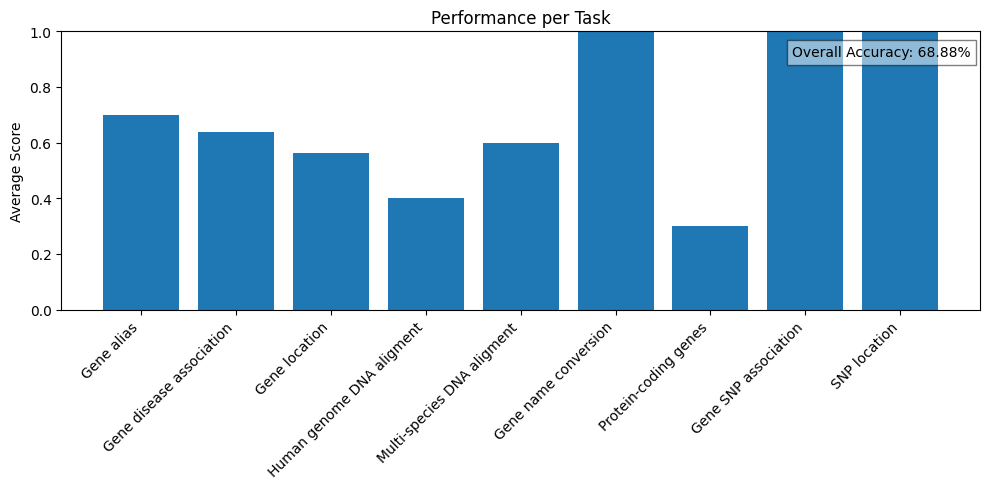

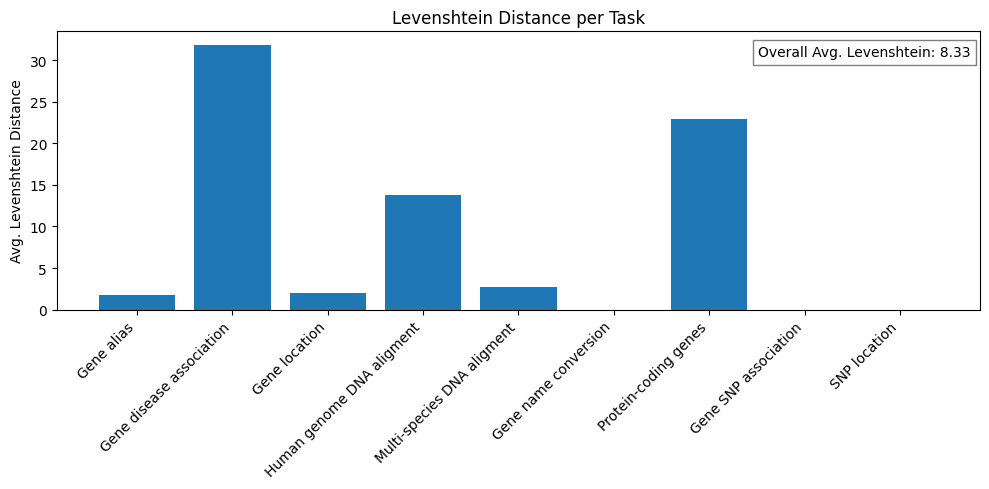

In [ ]:

from collections import defaultdict
from typing import Callable, Union, Dict, List, cast
import json
import matplotlib.pyplot as plt
def exact_match(pred: str, true: str) -> float:
    # if isinstance(pred, list):
    #     pred = [p.strip().lower() for p in pred]
    #     return float(true.strip().lower() in pred)
    # else:
    #     return float(pred.strip().lower() == true.strip().lower())
    if pred.strip().lower() == true.strip().lower():
        return 1.0
    else:
        return 0.0


def gene_disease_association(pred: list[str], true: list[str]) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)


def disease_gene_location(pred: list[str], true: list[str]) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)


def human_genome_dna_alignment(pred: str, true: str) -> float:
    pred = pred.strip().lower()
    true = true.strip().lower()
    if pred == true:
        return 1.0
    pred_chr = pred.split(":")[0]
    true_chr = true.split(":")[0]
    return 0.5 if pred_chr == true_chr else 0.0


MetricFunc = Callable[[Union[str, list[str]], Union[str, list[str]]], float]

metric_task_map: Dict[str, MetricFunc] = defaultdict(
    lambda: cast(MetricFunc, exact_match),
    {
        "Gene disease association": cast(MetricFunc, gene_disease_association),
        "Gene location": cast(MetricFunc, disease_gene_location),
        "Human genome DNA aligment": cast(MetricFunc, human_genome_dna_alignment),
    },
)


def evaluate_predictions_metric_based(data, metric_task_map):
    total_score = 0.0
    total_count = 0
    task_stats = defaultdict(lambda: {'score_sum': 0.0, 'count': 0, 'lev_sum': 0})
    total_lev_distance = 0
    
    for task, examples in data.items():
        metric = metric_task_map[task]
        for _, answers in examples.items():
            pred = answers["predicted"]
            true = answers["true"]

            # Convert strings like "['a', 'b']" to lists if needed
            if isinstance(pred, str) and pred.startswith("[") and pred.endswith("]"):
                pred = eval(pred)
            if isinstance(true, str) and true.startswith("[") and true.endswith("]"):
                true = eval(true)

            try:
                score = metric(pred, true)
            except Exception as e:
                print(f"Error in task {task}: {e}")
                score = 0.0


            lev = Levenshtein.distance(pred, true)
            total_lev_distance += lev
            task_stats[task]['lev_sum'] += lev
            
            total_score += score
            total_count += 1
            task_stats[task]['score_sum'] += score
            task_stats[task]['count'] += 1

    overall_score = total_score / total_count
    overall_lev = total_lev_distance / total_count
    print(f"\n🔎 Overall score: {overall_score:.2%}\n")
    print(f"\n🔎 Overall lev_distance: {overall_lev:.2%}\n")
    tasks = []
    accs = []
    lev_dists = []

    for task, stats in task_stats.items():
        acc = stats['score_sum'] / stats['count']
        avg_lev = stats['lev_sum'] / stats['count']
        print(f"Task: {task}")
        print(f"  Accuracy: {acc:.2%}")
        print(f"  Avg. Levenshtein distance: {avg_lev:.2f}\n")
        tasks.append(task)
        accs.append(acc)
        lev_dists.append(avg_lev)

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(tasks, accs)
    plt.ylabel('Average Score')
    plt.title('Performance per Task')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.text(0.99, 0.95, f'Overall Accuracy: {overall_score:.2%}',
             transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

    # Plot Levenshtein distance per task
    plt.figure(figsize=(10, 5))
    plt.bar(tasks, lev_dists)
    plt.ylabel('Avg. Levenshtein Distance')
    plt.title('Levenshtein Distance per Task')
    plt.xticks(rotation=45, ha='right')
    plt.text(0.99, 0.95, f'Overall Avg. Levenshtein: {overall_lev:.2f}',
             transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

with open('/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/geneturing_entrez.json') as f:
    data = json.load(f)

evaluate_predictions_metric_based(data, metric_task_map)